# Concevez une application au service de la santé publique  
# Première partie : nettoyage des données

---

**Vérification de l'environnement**

In [1]:
import sys
IN_COLAB = "google.colab" in sys.modules
PATH_DRIVE = "/content/drive/My Drive/MachineLearning/ML02" # to change according to your Google Drive folders

In [2]:
if IN_COLAB:
    print("Le notebook est exécuté sur Google Colab")
else:
    print("Le notebook est exécuté en local")

Le notebook est exécuté en local


In [3]:
if IN_COLAB:
    from google.colab import drive, files
    drive.mount('/content/drive')

---

## <font color=blue>Sommaire</font>

[1. Téléchargement des données](#1_0)  
  
[2. Restriction aux produits vendus en France (ou dans une liste de pays)](#2_0)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.1. Exploration du champs countries](#2_0)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.2. Filtrage des données brutes pour ne conserver que les données des produits vendus en France (ou dans une liste de pays)](#2_2)  
  
[3. Analyse du taux de remplissage des colonnes](#3_0)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.1. Détermination des colonnes avec des données manquantes](#3_0)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.2. Suppression des colonnes avec trop de données manquantes](#3_2)  
  
[4. Idée d'application](#4_0)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[4.1. Définition de l'idée d'application](#4_0)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[4.2. Définition des variables nécessaires pour cette application](#4_2)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[4.3. Projection sur les variables utiles à notre projet](#4_3)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[4.4. Restriction aux enregistrements utiles à notre projet](#4_4)  
  
[5. Suppression des doublons dans les lignes](#5_0)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[5.1. Doublons de lignes](#5_0)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[5.2. Doublons dans les code-barres](#5_2)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[5.3. Utilisation du code-barre comme index](#5_3)  
  
[6. Suppression des doublons dans les colonnes](#6_0)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[6.1. Doublon de variables : colonnes liées à la catégorie du produit](#6_0)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[6.2. Doublon de variables : colonnes liées au groupe pnns](#6_2)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[6.3. Doublon de variables : colonnes liées aux labels](#6_3)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[6.4. Doublon de variables : colonnes liées au nutriscore et au nutrigrade](#6_4)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[6.5. Doublon de variables : colonnes liées à l'énergie](#6_5)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[6.6. Doublon de variables : choix entre le sel et le sodium](#6_6)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[6.7. Projection sur les colonnes conservées pour l'application](#6_7)  
  
[7. Vérification et traitement des données aberrantes](#7_0)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[7.1. Données numériques qui doivent être positives ou nulles](#7_0)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[7.2. Données numériques qui doivent être inférieures ou égales à 100](#7_2)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[7.3. Saturated-fat doit être inférieur ou égal à fat](#7_3)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[7.4. Sugars doit être inférieur ou égal à carbohydrates](#7_4)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[7.5. La somme des macro-nutriments doit être inférieure ou égale à 100g](#7_5)  
  
[8. Traitement des valeurs manquantes](#8_0)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[8.1. Analyse des colonnes avec des valeurs manquantes](#8_0)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[8.2. Imputation avec une constante : additives_n et ingredients_from_palm_oil_n](#8_2)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[8.3. Vérification du nom des produits](#8_3)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[8.4. Imputation avec une valeur calculée : variables de mesures pour 100g](#8_4)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[8.5. Vérification du respect des contraintes numériques après l'imputation](#8_5)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[8.6. Nettoyages supplémentaires déduits de l'analyse des données](#8_6)  
  
[9. Sauvegarde des données nettoyées](#9_0)  

---
## <font color=blue>Set-up du notebook</font>

**Importation des librairies**

In [4]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import re
if IN_COLAB:
    import os
else:
    import requests

In [5]:
from IPython.display import Image
from sklearn.impute import SimpleImputer, KNNImputer

In [6]:
if IN_COLAB:
    sys.path.append(PATH_DRIVE)
    import sf_graphiques as sfg
else:
    import modules_perso.sf_graphiques as sfg

**Setup du notebook**

In [7]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [8]:
if IN_COLAB:
    os.chdir(PATH_DRIVE)

In [9]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = fig_id + "." + fig_extension
    if IN_COLAB:
        path = PATH_DRIVE + "/" + path
    #print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, dpi=resolution)

In [10]:
def mydefault_plt_parameters(figsize=(12,8)):
    plt.rcParams['figure.figsize'] = figsize
    if figsize[0] == 12:
        mult_param = 1.0
        plt.rcParams['font.size'] = 18
        plt.rcParams['axes.titlepad'] = 20
        plt.rcParams['axes.labelpad'] = 15
    else:
        mult_param = np.sqrt(1.0 * figsize[0] / 12)
        plt.rcParams['font.size'] = np.around(18 * mult_param)
        plt.rcParams['axes.titlepad'] = np.around(20 * mult_param)
        plt.rcParams['axes.labelpad'] = np.around(15 * mult_param)
    plt.rcParams['figure.titleweight'] = 'bold'
    plt.rcParams['axes.titleweight'] = 'bold'
    plt.rcParams['legend.framealpha'] = 1
    plt.rcParams['legend.facecolor'] = (0.95,0.95,0.95)
    plt.rcParams['legend.edgecolor'] = (0.95,0.95,0.95)
    plt.rcParams['savefig.orientation'] = 'landscape'
    plt.rcParams['savefig.dpi'] = 300
    plt.rcParams['savefig.bbox'] = 'tight'
mydefault_plt_parameters()

**Au préalable**

Après avoir téléchargé la base de données, j'ai pris le temps de lire la documentation disponible sur le site https://fr.openfoodfacts.org/ et notamment la description des variables. J'ai également étudié la connaissance métier, notamment sur le Nutriscore grâce au site Santé Publique France https://www.santepubliquefrance.fr/determinants-de-sante/nutrition-et-activite-physique/articles/nutri-score.  
J'ai ensuite exploré le dataset pour découvrir un aperçu des features présentes et ce qu'elles contiennent.

---
<a id='1_0'></a>

## <font color=blue>1. Téléchargement des données</font>

La base de données complète d'OpenFactFoods pèse plus de 2Go. Elle est disponible à l'adresse suivante : https://static.openfoodfacts.org/data/en.openfoodfacts.org.products.csv  
J'ai renommé ma copie locale 'base_openfoodfacts.csv'.  Une copie de cette base est disponible à https://drive.google.com/open?id=18peuOR9dTObEnNmHkz55DyP2oWL7CXFE  
La description des variables est disponible à l'adresse https://static.openfoodfacts.org/data/data-fields.txt  

In [11]:
# La base OpenFoodFacts est parfois corrompue (elle doit contenir plus d'un million de lignes).
url = 'https://static.openfoodfacts.org/data/en.openfoodfacts.org.products.csv'
if IN_COLAB:
    # Importation du fichier sur Google Collab
    raw_data = pd.read_csv(url, sep='\t')
else:
    # Importation du fichier en local
    # à décommenter pour mettre à jour le fichier local
    '''
    r = requests.get(url)
    with open('base_openfoodfacts.csv', 'wb') as f:
        f.write(r.content)
    '''
    raw_data = pd.read_csv("base_openfoodfacts.csv", sep='\t')

C:\Anaconda3\envs\Jupyter\lib\site-packages\IPython\core\interactiveshell.py:3044: DtypeWarning: Columns (0,24,25,26,28,44,49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [12]:
raw_data.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,0000000000017,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1529059080,2018-06-15T10:38:00Z,1561463718,2019-06-25T11:55:18Z,Vitória crackers,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000000031,http://world-en.openfoodfacts.org/product/0000...,isagoofy,1539464774,2018-10-13T21:06:14Z,1539464817,2018-10-13T21:06:57Z,Cacao,NaN,130 g,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,000000000003327986,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1574175736,2019-11-19T15:02:16Z,1574175737,2019-11-19T15:02:17Z,Filetes de pollo empanado,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0000000000100,http://world-en.openfoodfacts.org/product/0000...,del51,1444572561,2015-10-11T14:09:21Z,1444659212,2015-10-12T14:13:32Z,moutarde au moût de raisin,NaN,100g,...,NaN,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,00000000001111111111,http://world-en.openfoodfacts.org/product/0000...,openfoodfacts-contributors,1560020173,2019-06-08T18:56:13Z,1560020173,2019-06-08T18:56:13Z,Sfiudwx,NaN,dgesc,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
raw_data.shape

(1182513, 178)

<font color=red>Je dispose de 1.182.513 enregistrements et 178 variables (au 12 mars 2020).</font>

**REMARQUE : tous les commentaires chiffrés suivants sont basés sur les données au 12 mars 2020. Le notebook s'adapte aux nouvelles données. Aussi, les résultats des mesures peuvent légèrement variés des commentaires si vous téléchargez des données plus récentes.**

---
<a id='2_0'></a>

## <font color=blue>2. Restriction aux produits vendus en France (ou dans une liste de pays)</font>

### 2.1. Exploration du champs countries

Comme mon application se destine à la France, je me limite aux produits vendus en France.  
La documentation indique que les champs countries, countries_tags et countries_fr contiennent cette information. Elles sont identiques dans le contenu. Seul le format change. Je vérifie quelle colonne est la meilleure pour sélectionner le pays de vente, y compris lorsqu'il y a plusieurs pays de vente.

In [14]:
raw_data[["countries","countries_tags","countries_en"]].head(15)

,countries,countries_tags,countries_en
0,France,en:france,France
1,France,en:france,France
2,en:es,en:spain,Spain
3,France,en:france,France
4,en:France,en:france,France
5,France,en:france,France
6,France,en:france,France
7,France,en:france,France
8,en:france,en:france,France
9,France,en:france,France


In [15]:
raw_data[(raw_data.countries_en.str.len() > 6) & (raw_data.countries_tags.str.contains('france', case=False, regex=False, na=False))][["countries","countries_tags","countries_en"]].head(15)

,countries,countries_tags,countries_en
172,"États-Unis, en:france","en:france,en:united-states","France,United States"
210,"États-Unis, en:france","en:france,en:united-states","France,United States"
221,"France, United States","en:france,en:united-states","France,United States"
244,"France, United States","en:france,en:united-states","France,United States"
253,"France,États-Unis","en:france,en:united-states","France,United States"
374,"France, États-Unis","en:france,en:united-states","France,United States"
556,"Frankreich, Deutschland","en:france,en:germany","France,Germany"
557,"France,Germany,Netherlands","en:france,en:germany,en:netherlands","France,Germany,Netherlands"
589,"France,Switzerland","en:france,en:switzerland","France,Switzerland"
593,"Frankreich, en:de","en:france,en:germany","France,Germany"


Les colonnes les plus sûres pour la sélection du pays sont les colonnes countries_tags et countries_en où les noms de pays sont formatés de façon constante en anglais.  
**La colonne countries_tags présente l'avantage d'un formatage sans espace et de ne pas dépendre du langage** (il semble que certains liens donnent des champs tels que countries_fr au lieu de countries_en). Je vérifie les valeurs manquantes de ces colonnes.

In [16]:
raw_data[["countries","countries_tags","countries_en"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1182513 entries, 0 to 1182512
Data columns (total 3 columns):
countries         1180445 non-null object
countries_tags    1180443 non-null object
countries_en      1180443 non-null object
dtypes: object(3)
memory usage: 27.1+ MB


In [17]:
raw_data[raw_data.countries.notna() & raw_data.countries_tags.isna()][["countries","countries_tags","countries_en"]]

,countries,countries_tags,countries_en
787795,---,NaN,NaN
1146567,?,NaN,NaN


In [18]:
nb_manquantes = len(raw_data[raw_data.countries_tags.isna()])
print("Nombre de données manquantes dans 'countries_tags' = {} ({:.2%} de la base)".\
      format(nb_manquantes, nb_manquantes/len(raw_data)))

Nombre de données manquantes dans 'countries_tags' = 2070 (0.18% de la base)


Les données manquantes sont les mêmes pour les trois champs.  
Il y a très peu de données manquantes : un peu plus de 2000 valeurs manquantes sur plus d'un million de lignes, soit moins de 0,2% de la base de données. Remplir manuellement cette information est trop coûteuse en temps.

<font color=red>Je sélectionne les lignes où countries_tags contient 'france', ce qui supprime automatiquement les lignes où le champs 'countries_tags' n'est pas renseigné.</font>  
Afin de pouvoir faire évoluer facilement le pays analysé ou ajouter d'autres pays à mon application, je créer une liste contenant les pays de vente que je souhaite conserver.

<a id='2_2'></a>

### 2.2. Filtrage des données brutes pour ne conserver que les données des produits vendus en France (ou dans une liste de pays)

Je définis une fonction pour sélectionner les seules lignes qui correspondent aux produits vendus dans un pays ou une liste de pays.

In [19]:
def select_data_countries(df, countries_list):
    row_selected = np.full(len(df), False)
    for country in countries_list:
        row_selected = row_selected | df.countries_tags.str.contains(country, case=False, regex=False, na=False)
    return df[row_selected]

In [20]:
countries_list = ['france']
data = select_data_countries(raw_data, countries_list)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 669732 entries, 0 to 1182509
Columns: 178 entries, code to carnitine_100g
dtypes: float64(120), int64(2), object(56)
memory usage: 914.6+ MB


<font color=red>La base OpenFoodFacts comprend des données pour 669 732 produits vendus en France (au 12 mars 2020).</font>

In [21]:
raw_data = ''

<a id='3_0'></a>

---
## <font color=blue>3. Analyse du taux de remplissage des colonnes</font>

Je regarde le nombre de données manquantes par colonne. Je supprime les colonnes avec trop de données manquantes.

### 3.1. Détermination des colonnes avec des données manquantes

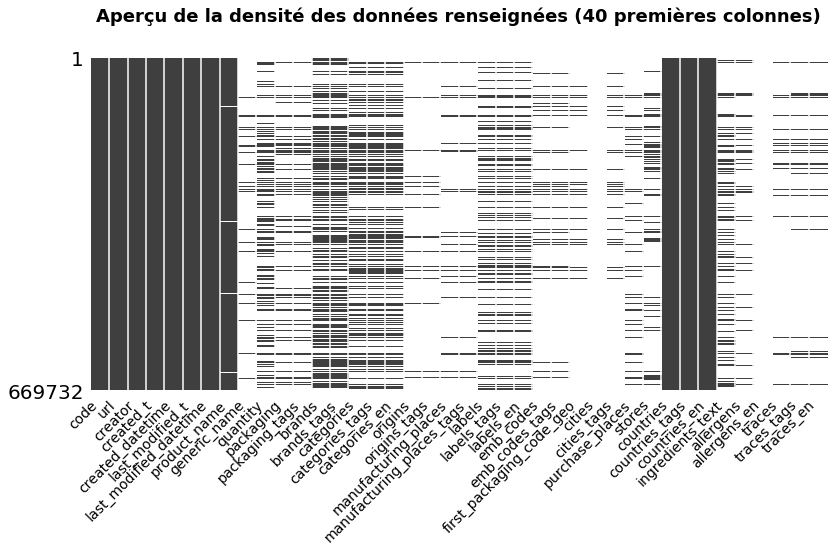

In [22]:
fig = plt.figure()
ax = plt.axes()
msno.matrix(data[data.columns[:40]], sparkline=False, ax=ax)
ticklabels = ax.xaxis.get_ticklabels()
ax.xaxis.set_ticks_position('bottom')
ax.xaxis.set_ticks_position('none')
ax.set_xticklabels(ticklabels, rotation=45, ha='right', fontsize=14)
plt.title("Aperçu de la densité des données renseignées (40 premières colonnes)", fontsize=18, y=1.05)
plt.tight_layout()
save_fig("101_apercu_donnees_manquantes")
plt.show()

Sur les 40 premières colonnes, je distingue trois catégories de variables :  
- celles qui n'ont pas ou très peu de valeurs manquantes ;  
- celles qui ont très peu de lignes renseignées. Celles-ci seront sans doute abandonnées ;  
- celles qui ont un taux de remplissage moyen, entre 40 et 60%. Les valeurs manquantes de ces colonnes pourront sans doute être imputées.  

Je classe les colonnes en fonction du nombres de données remplies.

In [23]:
percent_filled = pd.DataFrame(1.0 - (data.isna().sum() / len(data)), index=data.columns, columns=["percent"])
percent_filled.sort_values(by="percent", ascending=False, inplace=True)
percent_filled.head()

,percent
code,1.0
countries,1.0
countries_en,1.0
url,1.0
states,1.0


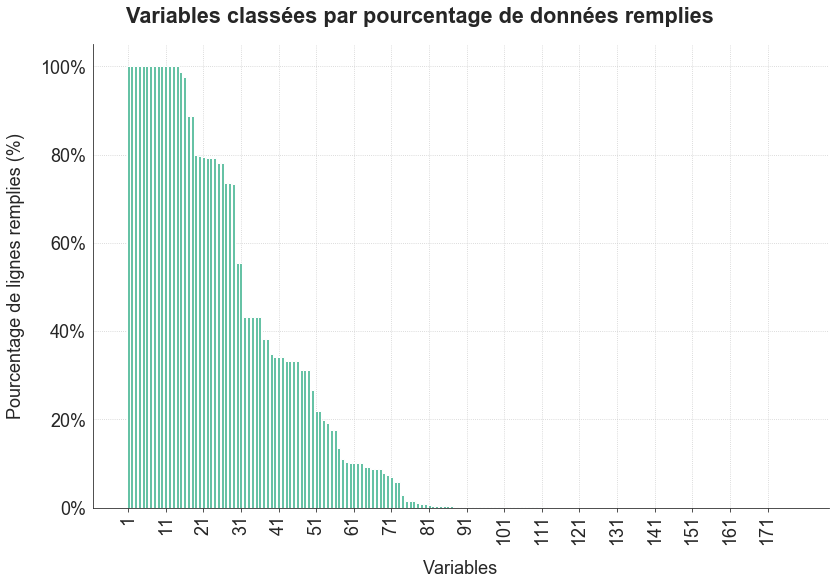

In [24]:
graph01 = sfg.MyGraph("Variables classées par pourcentage de données remplies")
graph01.add_barv(percent_filled.index, percent_filled.percent, with_grid='both')
graph01.set_axe_x(label="Variables", tick_min=0, tick_max=178, tick_step=10, 
                  tick_labels = np.arange(1, len(percent_filled)+1, 10), tick_dash=True, rotation=90)
graph01.set_axe_y(label="Pourcentage de lignes remplies (%)", tick_labels_format=':.0%')
fig, ax = graph01.fig, graph01.ax
save_fig("102_apercu_variables_remplies")
plt.show()

<a id='3_2'></a>

### 3.2. Suppression des colonnes avec trop de données manquantes

Je décide de supprimer les colonnes avec trop de données manquantes.  
**Je supprime systématiquement les colonnes avec plus de 95% de données manquantes.  
Pour les colonnes qui ont entre 80% et 95% de données manquantes, je vérifie leur intitulé pour être sûr de ne pas supprimer une colonne qui pourrait présenter un intérêt.**

In [25]:
def columns_missing_data(df, seuil_min, list_to_keep=None, drop=False):
    interdf = pd.DataFrame(df.isna().sum() / len(df), index=df.columns, columns=["missing_percent"])
    col_to_drop = list(interdf[interdf.missing_percent >= seuil_min].index)
    if list_to_keep is not None:
        for col in list_to_keep:
            if col in col_to_drop:  # line add to avoid error if the percentage of missing data changes when new entries add up
                col_to_drop.remove(col)
    if drop:
        return df.drop(columns=col_to_drop)
    return col_to_drop

**Nombre de colonnes avec plus de 95% de données manquantes**

In [26]:
col_to_drop_95 = columns_missing_data(data, seuil_min=0.95)
print("Il y a {} colonnes avec plus de 95% de données manquantes.".format(len(col_to_drop_95)))

Il y a 105 colonnes avec plus de 95% de données manquantes.


**Analyse des colonnes qui ont entre 90% et 95% de données manquantes**

In [27]:
col_to_drop_90 = columns_missing_data(data, seuil_min=0.9, list_to_keep=col_to_drop_95)
col_to_drop_90

['origins',
 'origins_tags',
 'manufacturing_places',
 'manufacturing_places_tags',
 'emb_codes',
 'emb_codes_tags',
 'first_packaging_code_geo',
 'cities_tags',
 'traces',
 'energy-kj_100g']

Dans cette liste, avec la connaissance métier et la lecture du fichier descriptif des colonnes présentes dans la base de données, <font color=red>**je décide de garder la colonne 'energy-kj_100g'** qui vient compléter les colonnes 'energy_100g' et 'energy-kcal_100g'</font>. Elle me permettra peut-être de renseigner certaines valeurs manquantes dans la colonne energy_100g.  
Je supprime les autres colonnes.

**Analyse des colonnes qui ont entre 80% et 90% de données manquantes**

In [28]:
col_to_drop_90 = columns_missing_data(data, seuil_min=0.9)
col_to_drop_80 = columns_missing_data(data, seuil_min=0.8, list_to_keep=col_to_drop_90)
col_to_drop_80

['generic_name',
 'purchase_places',
 'stores',
 'allergens',
 'traces_tags',
 'traces_en',
 'serving_size',
 'serving_quantity',
 'additives_tags',
 'additives_en',
 'fiber_100g']

Dans cette liste, avec la connaissance métier et la lecture du fichier descriptif des colonnes présentes dans la base de données, **<font color=red>je décide de conserver les colonnes 'fiber_100g' et 'serving_quantity'</font>**.  
Les fibres sont un marco-nutriment. Il me semble donc essentiel de garder cette information.  
Les données dans le dataset sont exprimées par 100g. Conserver la quantité d'une portion pourra peut-être expliquer certaines valeurs aberrantes.  
Je supprime les autres colonnes.

**Suppression des colonnes avec plus de 80% de données manquantes**

Je supprime toutes les colonnes à l'exception des 3 colonnes que j'ai identifiées comme intéressantes.

In [29]:
data = columns_missing_data(data, seuil_min=0.8,
                                 list_to_keep=["energy-kj_100g","serving_quantity","fiber_100g"], drop=True)

---
<a id='4_0'></a>

## <font color=blue>4. Idée d'application</font>

### 4.1. Définition de l'idée d'application

Je commence par regarder les colonnes qui restent à ma disposition.

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 669732 entries, 0 to 1182509
Data columns (total 55 columns):
code                                       669732 non-null object
url                                        669732 non-null object
creator                                    669731 non-null object
created_t                                  669732 non-null int64
created_datetime                           669732 non-null object
last_modified_t                            669732 non-null int64
last_modified_datetime                     669732 non-null object
product_name                               653001 non-null object
quantity                                   233386 non-null object
packaging                                  147336 non-null object
packaging_tags                             147330 non-null object
brands                                     371136 non-null object
brands_tags                                371100 non-null object
categories                      

Pour l'instant, j'ai réduit mon dataset à 55 colonnes au lieu des 178 colonnes initiales.  
Je vais pouvoir décider de mon application sur la base de ces 55 colonnes.

**<font color=red>Idée d'application</font>**

<font color=red>Scanner le code-barre sur l'emballage d'un aliment pour obtenir une notation de l'aliment concerné.</font>

Cette notation est basée sur une estimation du nutriscore à laquelle s'ajoute une attribution de points en fonction du caractère sain et écologique.

Le nutriscore donne une note entre -15 et +40. Une note plus faible signifie un meilleur produit. Pour obtenir un score plus lisible, l'estimation du nutriscore sera ensuite inversée puis ramener sur une échelle de 10 à 90 (10 étant désormais la moins bonne note).  
Pour prendre en compte le caractère sain et écologique du produit, nous enlèverons 5 points si un produit contient de l'huile de palme. Nous retirerons également un point par additif présent, dans la limite de 5 points.  
Enfin, la présence d'un label bio ajoutera un bonus de 10 points à la note obtenue.  
Les notes fournies par notre application iront donc de 0 à 100 et seront ainsi facilement interprétables par l'utilisateur.

<a id='4_2'></a>

### 4.2. Définition des variables nécessaires pour cette application

#### 4.2.1. Estimation du nutriscore

Nous ne pouvons pas calculer le nutriscore exact pour les aliments pour lesquels nous n'avons pas ce renseignement. En effet, nous ne disposons pas du détail du poids des différents ingrédients, et nous ne pouvons donc pas calculer le nutriscore exact.  
  
A la place, nous pouvons créer un modèle destiné à estimer ce nutriscore. Le modèle sera entraîné et évalué sur les produits pour lesquels nous disposons du nutriscore. Puis sa généralisation permettra d'estimer le nutriscore des autres produits.  
J'ai besoin des colonnes **energy_100g, saturated-fat_100g, sugars_100g, salt_100g, sodium_100g, fiber_100g et proteins_100g** pour estimer le nutriscore, puisque ces informations contribuent directement au calcul du nutriscore. Il manque le pourcentage de fruits, légumes, légumineuses, fruits à coque et huiles de colza, de noix et d'olive pour calculer précisément le nutriscore.  
Les colonnes **fat_100g et carbohydrates_100g** servent à décomposer d'une part les graisses en graisses saturées et non saturées, et d'autre part les glucides en sucres et autres glucides. Je conserve ces 2 colonnes car cette décomposition peut permettre d'obtenir un modèle plus précis.    
  
Nous avons également besoin de la colonne **nutrition-score-fr_100g ou nutriscore_score** pour créer notre modèle. Je conserve également en mémoire **nutriscore_grade** à des fins d'affichage.
  
Enfin, je conserve les colonnes **main_category, main_category_en, categories, categories_tags, categories_en** qui sont intéressantes si elles permetent de séparer les fromages et boissons des autres catégories. En effet, le nutriscore des fromages et des boissons ne se calcule pas de la même façon que celui des autres catégories d'aliment.  
Les colonnes **pnns_groups_1** et **pnns_groups_2** peuvent également servir à déterminer une catégorie. Je les conserve pour les étudier.  
Au final, je ne garderai qu'une seule colonne pour définir la catégorie du produit.

#### 4.2.2. Estimation du caractère sain et écologique

Pour les points attribués sur ce critère, j'utilise les colonnes :
- **ingredients_from_palm_oil_n** : nous privilégions les aliments sans huile de palme ;
- **additives_n** : nous privilégions les aliments sans additif ;
- **labels ou labels_tags ou labels_en** : nous privilégions les aliments avec un label bio.

#### 4.2.3. Présentation du produit

Je conserve 3 variables pour présenter le produit lorsqu'il est scanné :
- **code** : le code-barre qui nous permet d'identifier le produit ;
- **product_name** : le nom du produit ;
- **image_url** : un lien vers l'image du produit à afficher avec le score calculé.

#### 4.2.4. Variables pour le nettoyage des données

Je conserve provisoirement quelques colonnes pour le nettoyage des données :
- **image_nutrition_url et serving_quantity** : pour vérifier certaines données quantitatives si nécessaire ;
- **energy-kj_100g et energy-kcal_100g** : pour vérifier energy_100g.

<a id='4_3'></a>

### 4.3. Projection sur les variables utiles à notre projet

In [31]:
col_to_keep = ["code", "product_name", "image_url",
               "proteins_100g", "fat_100g", "carbohydrates_100g", "salt_100g", "sodium_100g", "fiber_100g",
               "saturated-fat_100g", "sugars_100g", "energy_100g",
               "nutrition-score-fr_100g", "nutriscore_score", "nutriscore_grade",
               "main_category", "main_category_en", "categories", "categories_tags", "categories_en",
               "pnns_groups_1", "pnns_groups_2",
               "ingredients_from_palm_oil_n", "additives_n", "labels", "labels_tags", "labels_en",
               "image_nutrition_url", "serving_quantity", "energy-kcal_100g", "energy-kj_100g"]
data = data[col_to_keep]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 669732 entries, 0 to 1182509
Data columns (total 31 columns):
code                           669732 non-null object
product_name                   653001 non-null object
image_url                      594904 non-null object
proteins_100g                  532930 non-null float64
fat_100g                       530664 non-null float64
carbohydrates_100g             530458 non-null float64
salt_100g                      523300 non-null float64
sodium_100g                    523296 non-null float64
fiber_100g                     127800 non-null float64
saturated-fat_100g             531286 non-null float64
sugars_100g                    531675 non-null float64
energy_100g                    535167 non-null float64
nutrition-score-fr_100g        227916 non-null float64
nutriscore_score               227911 non-null float64
nutriscore_grade               227911 non-null object
main_category                  289088 non-null object
main_category

<a id='4_4'></a>

### 4.4. Restriction aux enregistrements utiles à notre projet

#### 4.4.1. Analyse de la densité des données renseignées sur les colonnes conservées

**Analyse par colonne**

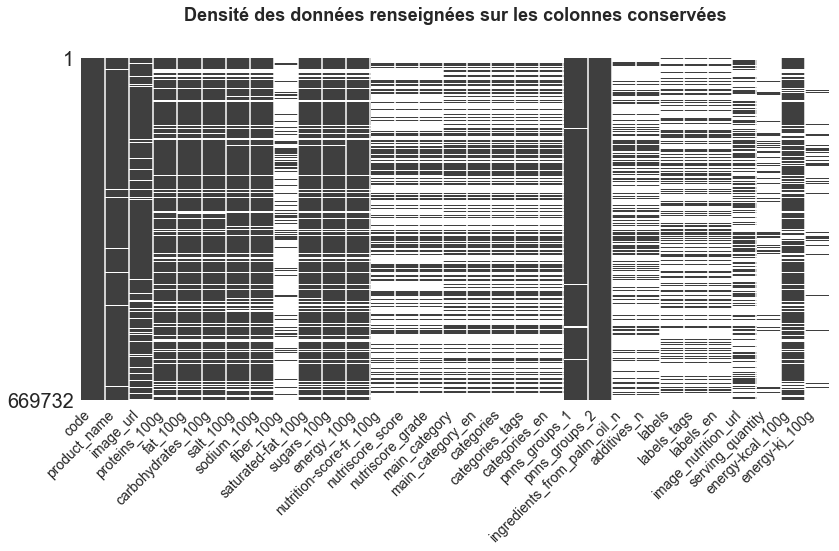

In [32]:
fig = plt.figure()
ax = plt.axes()
msno.matrix(data, sparkline=False, ax=ax)
ticklabels = ax.xaxis.get_ticklabels()
ax.xaxis.set_ticks_position('bottom')
ax.xaxis.set_ticks_position('none')
ax.set_xticklabels(ticklabels, rotation=45, ha='right', fontsize=14)
plt.title("Densité des données renseignées sur les colonnes conservées", fontsize=18, y=1.05)
plt.tight_layout()
save_fig("103_densite_donnees_remplies_v1")
plt.show()

Le code-barre est renseigné pour toutes les lignes.  
Le nom du produit et l'url de l'image ont très peu de valeurs manquantes.  
Les macro-nutriments ont tous un bon taux de remplissage, à l'exception des fibres pour 100g qui ont beaucoup plus de données manquantes. Cette donnée n'est pas toujours renseignée sur les emballages, et surtout tous les aliments n'ont pas un taux significatif de fibres.  
Le nutriscore n'est pas disponible pour tous les produits. Notre objectif est de créer un modèle qui permettra d'obtenir une note qui soit une estimation du nutriscore pour tous les produits, grâce à la généralisation de notre modèle.  
Les colonnes de catégorie sont remplies pour environ la moitié des lignes alors que les colonnes de groupes pnns n'ont quasiment pas de données manquantes.  
Les autres données relatives au caractère sain et écologique du produit ont plus de valeurs manquantes. Cette absence de données est logique car tous les produits ne contiennent pas d'ingrédient dérivés de l'huile de palme ou d'additifs, tous n'ont pas de labels.

**Analyse de la corrélation des taux de remplissage des colonnes**

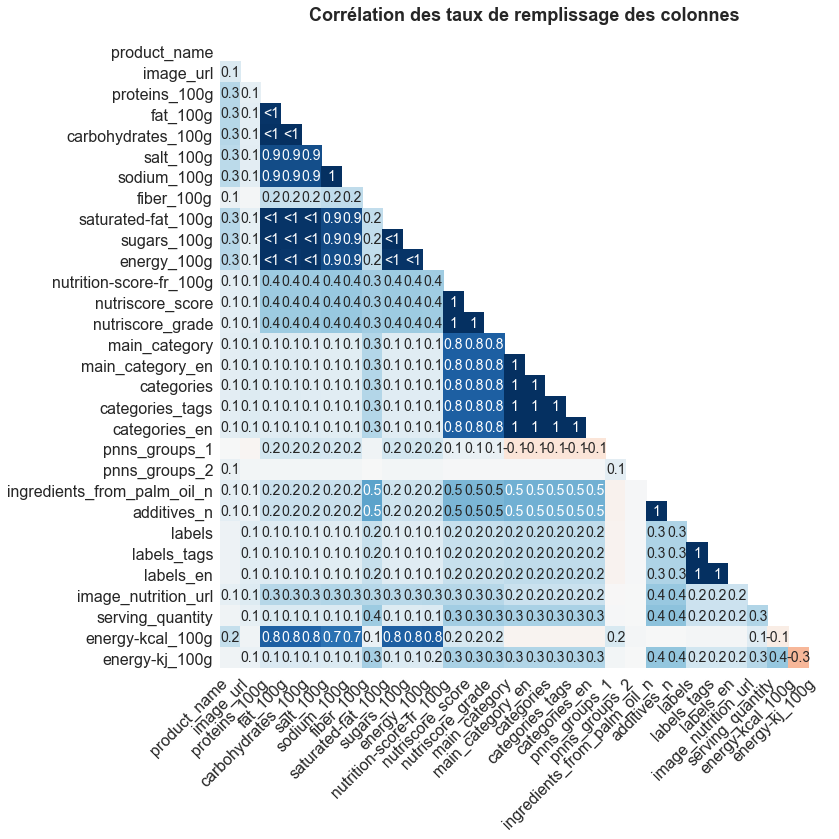

In [33]:
fig = plt.figure(figsize=(12,12))
ax = plt.axes()
msno.heatmap(data, cbar=False, ax=ax)
plt.title("Corrélation des taux de remplissage des colonnes", fontsize=18, y=1.05)
plt.tight_layout()
save_fig("104_correlation_donnees_remplies_v1")
plt.show()

La corrélation entre les taux de remplissage des colonnes montre que les colonnes concernant les macro-aliments (et leur sous-catégorie principale) et l'énergie sont en général remplies sur les mêmes enregistrements (corrélations proches de 1), à l'exception du sel dont les champs remplis diffèrent plus des autres enregistrements (corrélation de 0,9) et des fibres pour lesquelles nous disposons de beaucoup moins de données (comme vu précédemment).

#### 4.4.2. Restriction aux enregistrements utiles

Le nutriscore est essentiellement basé sur les macro-nutriments du produit, soit les colonnes proteins_100g, fat_100g, carbohydrates_100g, salt_100g (ou sodium_100g) et fiber_100g.  
Les colonnes energy_100g, sugars_100g, saturated-fat_100g peuvent également être utiles pour estimer le nutriscore.  
La colonne energy peut être calculée à partir des colonnes proteins_100g, fat_100g et carbohydrates_100g. Les colonnes sugars_100g et saturated-fat_100g sont des sous-catégories de carbohydrates_100g et fat_100g.  
Les colonnes salt_100g et fiber_100g ont plus de données manquantes que les autres colonnes mentionnées.

**Les colonnes proteins_100g, fat_100g et carbohydrates_100g sont donc trois colonnes essentielles pour notre application et pour la base de données. Si aucune d'elle n'est remplie, je peux douter de la fiabilité de l'enregistrement.**

Sur la base de cette analyse et de la corrélation des remplissages, je décide de **<font color=red>supprimer les lignes qui n'ont aucune valeur pour les colonnes proteins_100g, fat_100g et carbohydrates_100g</font>**.

In [34]:
def check_essentials_col_notna(df):
    col_essentials = ["proteins_100g", "fat_100g", "carbohydrates_100g"]
    return df.dropna(how='all', subset=col_essentials)

In [35]:
data = check_essentials_col_notna(data)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533722 entries, 0 to 1182509
Data columns (total 31 columns):
code                           533722 non-null object
product_name                   532382 non-null object
image_url                      481860 non-null object
proteins_100g                  532930 non-null float64
fat_100g                       530664 non-null float64
carbohydrates_100g             530458 non-null float64
salt_100g                      516828 non-null float64
sodium_100g                    516825 non-null float64
fiber_100g                     127780 non-null float64
saturated-fat_100g             531268 non-null float64
sugars_100g                    531595 non-null float64
energy_100g                    533259 non-null float64
nutrition-score-fr_100g        227399 non-null float64
nutriscore_score               227394 non-null float64
nutriscore_grade               227394 non-null object
main_category                  247290 non-null object
main_category

#### 4.4.3. Analyse de la densité des données renseignées sur les colonnes et les lignes conservées

Je regarde à nouveau les taux de remplissage et la corrélation entre les lignes remplies, sur les seules lignes conservées.

**Analyse par colonne**

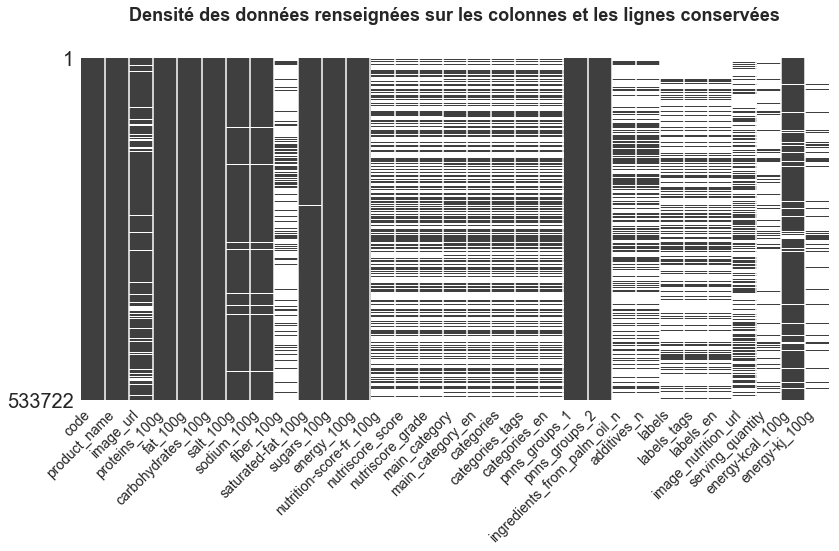

In [36]:
fig = plt.figure()
ax = plt.axes()
msno.matrix(data, sparkline=False, ax=ax)
ticklabels = ax.xaxis.get_ticklabels()
ax.xaxis.set_ticks_position('bottom')
ax.xaxis.set_ticks_position('none')
ax.set_xticklabels(ticklabels, rotation=45, ha='right', fontsize=14)
plt.title("Densité des données renseignées sur les colonnes et les lignes conservées", fontsize=18, y=1.05)
plt.tight_layout()
save_fig("105_densite_donnees_remplies_v2")
plt.show()

In [37]:
percent_filled = pd.DataFrame(1.0 - (data.isna().sum() / len(data)), index=data.columns, columns=["percent"])
percent_filled.sort_values(by="percent", ascending=False, inplace=True)
percent_filled.head()

,percent
code,1.000000
pnns_groups_2,1.000000
energy_100g,0.999133
proteins_100g,0.998516
pnns_groups_1,0.997864


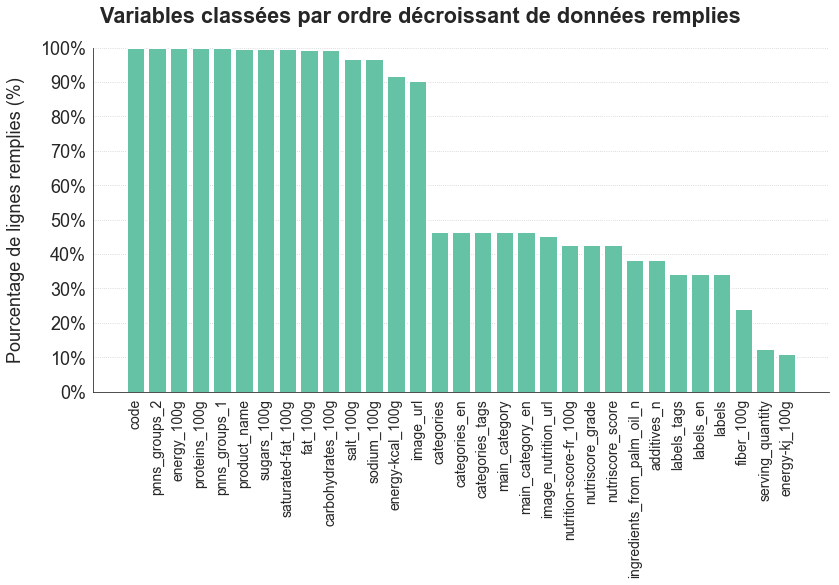

In [38]:
graph = sfg.MyGraph("Variables classées par ordre décroissant de données remplies")
graph.add_barv(percent_filled.index, percent_filled.percent)
graph.set_axe_x(rotation=90)
graph.set_axe_y(label="Pourcentage de lignes remplies (%)", tick_min=0, tick_max=1.0, tick_step=0.1, tick_labels_format=':.0%')
fig, ax = graph.fig, graph.ax
ax[0].tick_params(axis="x", labelsize=14)
save_fig("106_classement_donnees_remplies_v2")
plt.show()

Le nombre de valeurs manquantes a diminué pour toutes les colonnes essentielles à notre modèle.

In [39]:
print("Je dispose du nutriscore pour {:.2%} des données, sur lesquelles je vais pouvoir construire et évaluer \
mon modèle avant de le généraliser sur les autres données".format(len(data[data["nutrition-score-fr_100g"].notna()])/len(data)))

Je dispose du nutriscore pour 42.61% des données, sur lesquelles je vais pouvoir construire et évaluer mon modèle avant de le généraliser sur les autres données


**Analyse de la corrélation des taux de remplissage des colonnes**

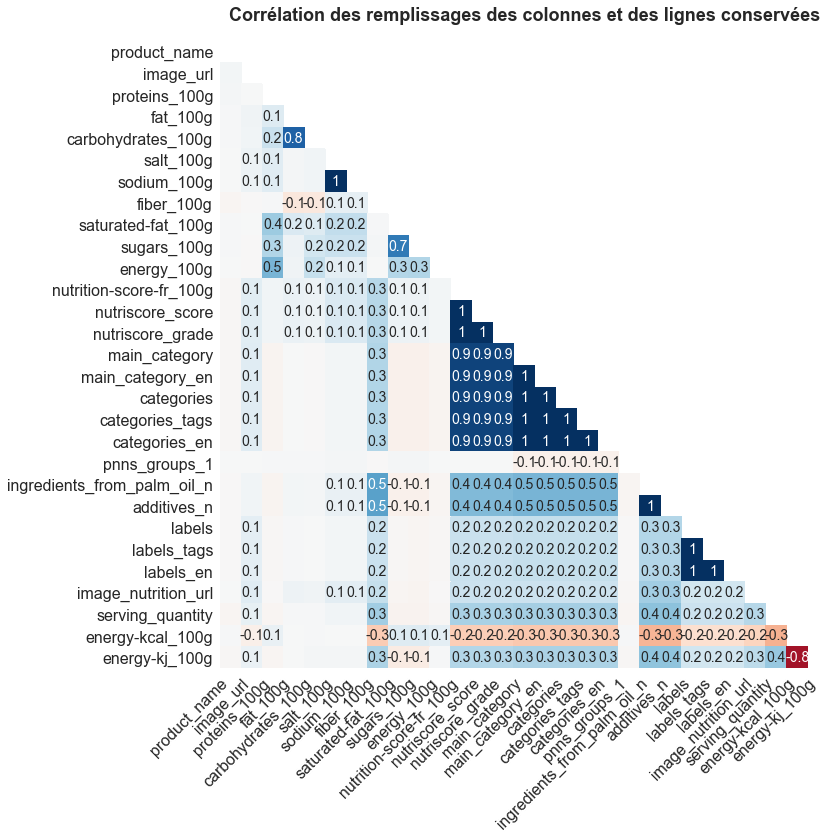

In [40]:
fig = plt.figure(figsize=(12,12))
ax = plt.axes()
msno.heatmap(data, cbar=False, ax=ax)
plt.title("Corrélation des remplissages des colonnes et des lignes conservées", fontsize=18, y=1.05)
plt.tight_layout()
save_fig("107_correlation_donnees_remplies_v2")
plt.show()

La corrélation entre les taux de remplissage des colonnes montre que :
- les 5 colonnes de catégorie sont renseignées sur les mêmes lignes : **il faut choisir une seule colonne de catégorie et la comparer aux groupes pnns** ;
- les 3 colonnes de labels sont renseignées sur les mêmes lignes : **il faut choisir une seule colonne de labels** ;
- les 2 colonnes de nutriscore et la colone de nutrigrade sont renseignées sur les mêmes lignes : **il faut choisir une seule colonne de nutriscore et conserver le nutrigrade** ;
- je dispose du nutriscore pour à peu près toutes les lignes pour lesquelles nous avons la catégorie (corrélation de 0,9);
- le nombre d'additifs est rempli lorsque le nombre d'ingrédients issus de l'huile de palme est indiqué ;
- le sel et le sodium sont disponibles pour les mêmes enregistrements : **il faut choisir entre le sel et le sodium** ;
- les remplissages de l'énergie en kj et en kcal se complètent (corrélation de remplissage négative à -0,8) et ne sont pas corrélés avec ceux de l'énergie pour 100g : **il faut étudier si l'énergie en kj et en kcal permet de compléter des valeurs manquantes pour l'énergie pour 100g** ;
- les colonnes carbohydrates et fat ont des données manquantes sur à peu près les mêmes lignes (corrélation de 0,8) ;
- les colonnes sugars et saturated_fat sont généralement renseignées simultanément (corrélation de 0,7).

---
<a id='5_0'></a>

## <font color=blue>5. Suppression des doublons dans les lignes</font>

### 5.1. Doublons de lignes

Je vérifie s'il existe des lignes en doublon sur tous les champs.

In [41]:
verif_doublons = data.duplicated()
len(verif_doublons[verif_doublons==True])

11

<font color=red>Je supprime les 11 lignes en doublon.</font>

In [42]:
def remove_duplicates_full(df):
    return df.drop_duplicates()
data = remove_duplicates_full(data)

<a id='4_2'></a>

<a id='5_2'></a>

### 5.2. Doublons dans les code-barres

Je vérifie s'il existe des doublons dans les codes barres

Pour ce faire, je dois transformer le code en chaine de caractère pour avoir le même type de données pour toutes les lignes.

In [43]:
data["code"] = data.code.astype(str)
test = data.copy()
test["nb_nul"] = test.isna().sum(axis=1)
test.sort_values(by=["nb_nul","code"], ascending=True, inplace=True)
test["tous_doublons"] = test.duplicated(subset=["code"], keep=False)  # variable avec les lignes de tous les doublons
len(test[test.tous_doublons])

252

Je vérifie les valeurs du champ product_name pour les lignes où il y a des doublons dans les code-barres.

In [44]:
test[test.tous_doublons].product_name.values

array(['Chargrilled Vegetable & Basil Pesto',
       'Wholemeal Pittas Enriched with Extra Virgin Olive Oil',
       'New York Vanilla Cheesecake', "Beurre D'arachide (croquant)",
       "Ben & Jerry's Glace Cookie Dough Vanille 500 ml",
       "Ben & Jerry's Glace Pot Chocolat Fudge Brownie 500ml",
       'Vegetable Pasta Bake with Broccoli & Petit Pois',
       'Salade Couscous Et Legumes Grilles', 'Cookies au Beurre',
       'Soya iced coffee drink', 'Ginger snaps',
       'Panda Brand, Oyster Flavored Sauce', nan, '2 half ciabata',
       "Ben & Jerry's Crème Glacée Pot Half Baked Cookie et Brownie 500ml",
       'Nerds', 'Coconut water', 'Tomme de chevre',
       'Salade chou,pomme,céleri', 'chorizo bio', 'chorizo bio',
       'Crevettes tropicales cuites décortiquées',
       'Creamy Caesar Dressing', 'Japanese green tea',
       'Christmas Pudding', 'Christmas Pudding', 'Salade Trois Haricots',
       'Lamb rogan josh', "Crème de marrons de l'Ardèche",
       'Champignons de Par

On remarque que les produits dont le code-barre est en doublon sont les mêmes produits, même si leur nom diffère parfois légèrement (précision dans l'appellation ou langue différente). Je peux supprimer ces doublons.

<font color=red>Je conserve les lignes avec le moins d'informations manquantes. Puis je vérifie si les lignes supprimées me permettent de renseigner des champs vides dans les lignes conservées.</font>

In [45]:
test["delete_doublons"] = test.duplicated(subset="code", keep='first')  # variable avec les lignes de doublon à supprimer
test["keep_doublons"] = test.tous_doublons & (test.delete_doublons == False)  # variable avec lignes de doublon à conserver
print("Il y a {} lignes à supprimer et {} lignes à conserver".\
      format(len(test[test.delete_doublons]),len(test[test.keep_doublons])))

Il y a 126 lignes à supprimer et 126 lignes à conserver


In [46]:
def remove_duplicates_code(df):
    df["code"] = df.code.astype(str)
    test = df.copy()
    test["nb_nul"] = test.isna().sum(axis=1)
    test.sort_values(by=["nb_nul","code"], ascending=True, inplace=True)
    test["tous_doublons"] = test.duplicated(subset=["code"], keep=False)  # variable avec les lignes de tous les doublons
    test["delete_doublons"] = test.duplicated(subset="code", keep='first')  # variable avec les lignes de doublon à supprimer
    test["keep_doublons"] = (test.tous_doublons) & (test.delete_doublons == False)  # variable avec lignes de doublon à conserver
    index_to_drop = list(test[test.delete_doublons].index)
    if index_to_drop:
        df.drop(index_to_drop, inplace=True)
        for idx_keep in list(test[test.keep_doublons].index):
            for col in df.columns:
                if pd.isna(df.loc[idx_keep,col]):
                    for idx_delete in list(test[(test.delete_doublons) & (test.code == df.loc[idx_keep].code)].index):
                        if (pd.isna(test.loc[idx_delete,col]) == False):
                            df.loc[idx_keep,col] = test.loc[idx_delete,col]
    return df

In [47]:
data = remove_duplicates_code(data)

**Remplissage des valeurs manquantes et nulles dans les lignes retenues à partir des lignes supprimées quand cela est possible**

In [48]:
index_to_check = list(test[test.keep_doublons].index)
verif_old_nb_na = test.loc[index_to_check].isna().sum(axis=1)

In [49]:
verif_new_nb_na = data.loc[index_to_check].isna().sum(axis=1)
print("{} valeurs manquantes ont été remplies grâce aux colonnes supprimées".\
      format(verif_old_nb_na.sum() - verif_new_nb_na.sum()))

31 valeurs manquantes ont été remplies grâce aux colonnes supprimées


Je vérifie que tous les doublons sur le code-barre ont été supprimés.

In [50]:
essai = data.duplicated(subset="code")
len(essai[essai==True])

0

<a id='5_3'></a>

### 5.3. Utilisation du code-barre comme index

Le code-barre est renseigné pour toutes les lignes. Il permet d'identifier de manière certaine un produit : il est unique et ne doit pas changer.  
Utiliser le code-barre permet d'être sûr de toujours identifier le même produit, même si l'ordre des enregistrements dans la base de données a changé.

In [51]:
data.code.is_unique

True

In [52]:
def code_as_index(df):
    return df.set_index("code")
data = code_as_index(data)
data.head(5)

,product_name,image_url,proteins_100g,fat_100g,carbohydrates_100g,salt_100g,sodium_100g,fiber_100g,saturated-fat_100g,sugars_100g,...,pnns_groups_2,ingredients_from_palm_oil_n,additives_n,labels,labels_tags,labels_en,image_nutrition_url,serving_quantity,energy-kcal_100g,energy-kj_100g
code,,,,,,,,,,,,,,,,,,,,,
0000000000017,Vitória crackers,https://static.openfoodfacts.org/images/produc...,7.8,7.0,70.1,1.40,0.560000,NaN,3.08,15.0,...,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1569.0,NaN
0000000000100,moutarde au moût de raisin,https://static.openfoodfacts.org/images/produc...,5.1,8.2,29.0,4.60,1.811024,0.0,2.20,22.0,...,Dressings and sauces,0.0,1.0,Delois france,fr:delois-france,fr:delois-france,NaN,NaN,NaN,936.0
0000000000123,Sauce Sweety chili 0%,https://static.openfoodfacts.org/images/produc...,0.2,0.0,4.8,2.04,0.816000,NaN,0.00,0.4,...,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,88.0,NaN
0000000000178,Mini coco,https://static.openfoodfacts.org/images/produc...,2.0,3.0,10.0,1.15,0.460000,NaN,1.00,3.0,...,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,251.0,NaN
0000000000949,Salade de carottes râpées,https://static.openfoodfacts.org/images/produc...,0.9,0.3,5.3,0.42,0.168000,NaN,0.10,3.9,...,One-dish meals,NaN,NaN,NaN,NaN,NaN,NaN,NaN,134.0,NaN


---
<a id='6_0'></a>

## <font color=blue>6. Suppression des doublons dans les colonnes</font>

### 6.1. Doublon de variables : colonnes liées à la catégorie

Si je conserve une colonne de catégorie, je dois n'en garder qu'une seule.  
Je devrais ensuite la comparer aux groupes pnns.

**Nombre de données manquantes**

Je regarde le nombre de valeurs manquantes et si des lignes ne contiennent des données que sur certaines colonnes.

In [53]:
col_analysis = ["categories","categories_tags","categories_en","main_category","main_category_en"]
data[col_analysis].isna().sum()

categories          286307
categories_tags     286307
categories_en       286307
main_category       286307
main_category_en    286307
dtype: int64

In [54]:
data[col_analysis].isna().sum(axis=1).unique()

array([5, 0], dtype=int64)

J'ai le même nombre de valeurs manquantes pour chaque colonne.  
Chaque ligne contient soit aucune valeur pour les colonnes de catégorie (nombre de colonnes manquantes = 5) soit une valeur pour chacune des colonnes de catégorie (nombre de colonnes manquantes = 0).  
**Je ne perds donc pas d'information quelque soit la colonne choisie.**

**Données contenues dans les différentes colonnes**

J'analyse un échantillon du contenu des différentes colonnes de catégorie.

In [55]:
data[col_analysis].dropna(how='all').head()

,categories,categories_tags,categories_en,main_category,main_category_en
code,,,,,
0000000000100,"Epicerie, Condiments, Sauces, Moutardes","en:groceries,en:condiments,en:sauces,en:mustards","Groceries,Condiments,Sauces,Mustards",en:groceries,Groceries
0000000000949,"Plats préparés, Légumes préparés, Carottes râp...","en:meals,en:prepared-vegetables,en:grated-carr...","Meals,Prepared vegetables,Grated carrots,Seaso...",en:meals,Meals
0000000001281,"Tartes, Tartes sucrées, Tartes à la noix de coco","en:pies,en:sweet-pies,en:coconut-pies","Pies,Sweet pies,Coconut pies",en:pies,Pies
0000000001885,"Aliments et boissons à base de végétaux, Alime...","en:plant-based-foods-and-beverages,en:plant-ba...","Plant-based foods and beverages,Plant-based fo...",en:plant-based-foods-and-beverages,Plant-based foods and beverages
0000000002257,"Plats préparés, Légumes préparés, Entrées, Ent...","en:meals,en:prepared-vegetables,en:starters,en...","Meals,Prepared vegetables,Starters,Cold starte...",en:meals,Meals


Les colonnes main_category corresponde à la catégorie principale des colonnes categories. Je privilégie une des deux colonnes main_category car seule la catégorie principale d'un aliment est susceptible de m'intéresser pour mon étude.  
Le format de main_category correspond au format de categories_tags. Comme il n'y a qu'une catégorie principale, il n'y a aucune séparation par virgule dans main_category.

**Comparaison de main_category et main_category_en**

In [56]:
cat_values = data.main_category.value_counts()
len(cat_values)

3973

In [57]:
cat_values_en = data.main_category_en.value_counts()
len(cat_values_en)

3973

Il y a 3973 catégories principales différentes, que ce soit dans main_category ou dans main_category_en.  
Ce nombre est bien trop important pour créer un diagramme circulaire lisible.

Je dois regrouper les catégories qui ont le moins d'enregistrements dans une autre catégorie principale, que je nomme "regroupement-n-autres".  
Puis je regarde un histogramme de distribution qui sera plus lisible avec beaucoup d'étiquettes.

In [58]:
regroupement = cat_values[20:].copy()
regroupement_nom = "regroupement-{}-autres".format(len(regroupement))
cat_values.drop(regroupement.index, inplace=True)
cat_values[regroupement_nom] = regroupement.values.sum()

In [59]:
regroupement_en = cat_values_en[20:].copy()
regroupement_nom = "regroupement-{}-autres".format(len(regroupement_en))
cat_values_en.drop(regroupement_en.index, inplace=True)
cat_values_en[regroupement_nom] = regroupement_en.values.sum()

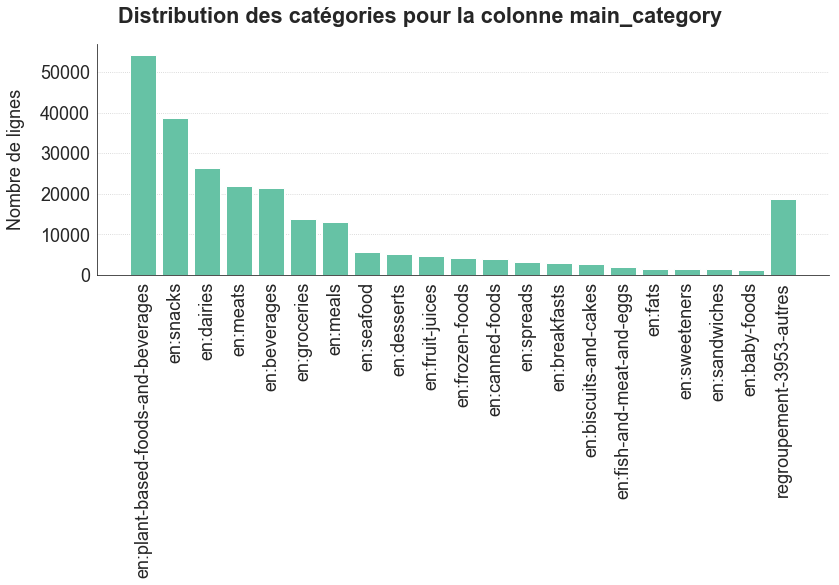

In [60]:
graph01 = sfg.MyGraph("Distribution des catégories pour la colonne main_category", figsize=(12,8))
graph01.add_barv(cat_values.index, cat_values.values)
graph01.set_axe_x(rotation=90, ha='center')
graph01.set_axe_y(label="Nombre de lignes")
fig, ax = graph01.fig, graph01.ax
save_fig("108_distribution_main_category")
plt.show()

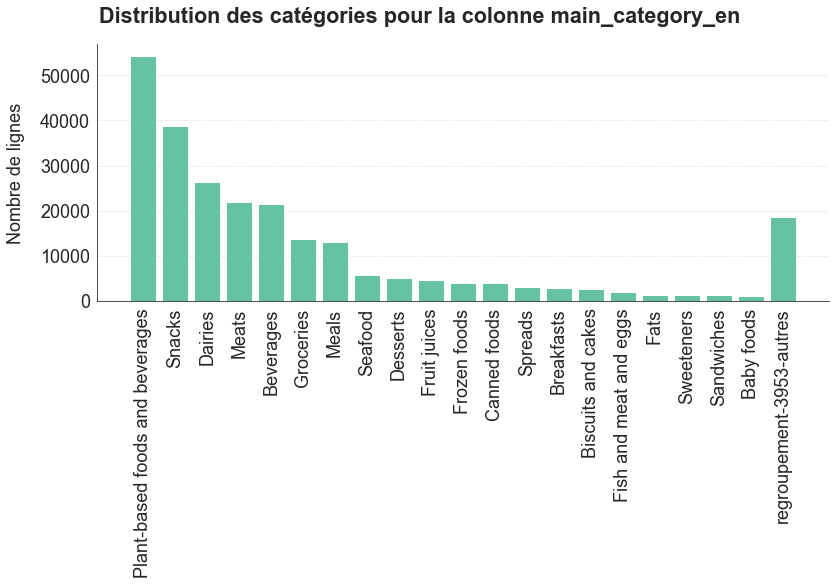

In [61]:
graph02 = sfg.MyGraph("Distribution des catégories pour la colonne main_category_en", figsize=(12,8))
graph02.add_barv(cat_values_en.index, cat_values_en.values)
graph02.set_axe_x(rotation=90, ha='center')
graph02.set_axe_y(label="Nombre de lignes")
fig, ax = graph02.fig, graph02.ax
save_fig("109_distribution_main_category_en")
plt.show()

In [62]:
np.array_equal(cat_values.values, cat_values_en.values)

True

Les deux colonnes main_category et main_category_en sont identiques : elles ont les mêmes noms de catégorie principale et la même distribution entre les différentes catégories principales.  
La seule différence entre les deux colonnes est le formatage du nom de la catégorie.

Cependant, ces colonnes ne sont pas exploitables dans le cadre de mon application car il y a trop de catégories principales différentes. D'autant plus qu'il n'y a aucune catégorie principale conséquente appelée 'cheese'.

**<font color=red>J'abandonne donc l'idée d'utiliser les colonnes de catégorie.</font>**

<a id='6_2'></a>

### 6.2. Doublon de variables : colonnes liées au groupe pnns

Si je conserve une colonne de groupe pnns, je dois n'en garder qu'une seule.

**Nombre de données manquantes**

Je regarde le nombre de valeurs manquantes.

In [63]:
col_analysis = ["pnns_groups_1","pnns_groups_2"]
data[col_analysis].isna().sum()

pnns_groups_1    1140
pnns_groups_2       0
dtype: int64

Il manque quelques données pour la colonne pnns_groups_1 alors que la colonne pnns_groups_2 est remplie pour toutes les lignes.

**Données contenues dans les différentes colonnes**

J'analyse un échantillon du contenu des différentes colonnes de catégorie.

In [64]:
data[col_analysis].dropna(how='all').head()

,pnns_groups_1,pnns_groups_2
code,,
0000000000017,unknown,unknown
0000000000100,Fat and sauces,Dressings and sauces
0000000000123,unknown,unknown
0000000000178,unknown,unknown
0000000000949,Composite foods,One-dish meals


La colonne pnns_groups_1 semble correspondre à un niveau d'agrégation supérieur. Je regarde quelles sont les valeurs différentes contenues dans chaque groupe pour confirmer cette impression.  
Je remarque également des valeurs 'unknown'.

In [65]:
pnns_values_1 = data.pnns_groups_1.value_counts()
len(pnns_values_1)

14

In [66]:
pnns_values_2 = data.pnns_groups_2.value_counts()
len(pnns_values_2)

46

La présence de plus de valeurs différentes pour les groupes pnns 2 confirme que ces groupes sont plus détaillés que les groupes pnns 1.

In [67]:
regroupement = pnns_values_1[5:].copy()
regroupement_nom = "regroupement-{}-autres".format(len(regroupement))
pnns_values_1.drop(regroupement.index, inplace=True)
pnns_values_1[regroupement_nom] = regroupement.values.sum()

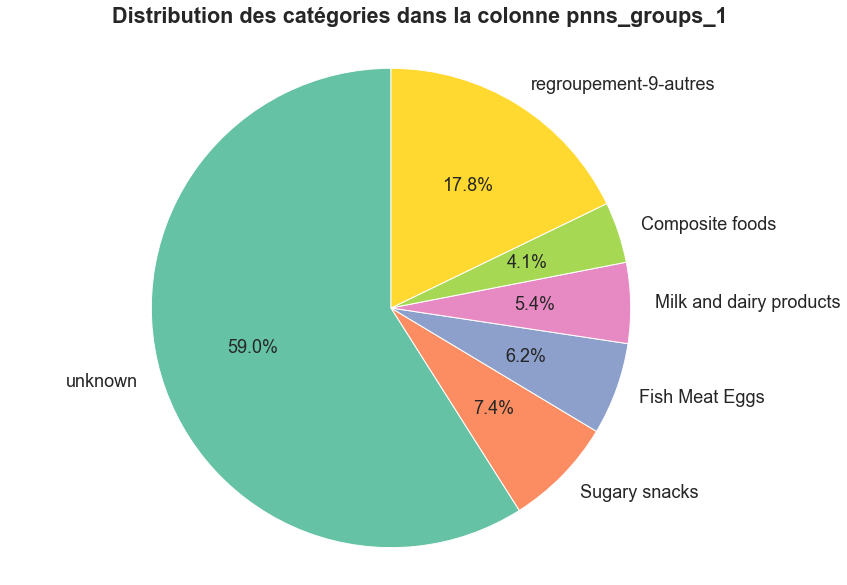

In [68]:
graph03 = sfg.MyGraph("Distribution des catégories dans la colonne pnns_groups_1")
graph03.add_pie(pnns_values_1.values, pnns_values_1.index)
fig, ax = graph03.fig, graph03.ax
save_fig("110_distribution_pnns_groups_1")
plt.show()

In [69]:
regroupement = pnns_values_2[5:].copy()
regroupement_nom = "regroupement-{}-autres".format(len(regroupement))
pnns_values_2.drop(regroupement.index, inplace=True)
pnns_values_2[regroupement_nom] = regroupement.values.sum()

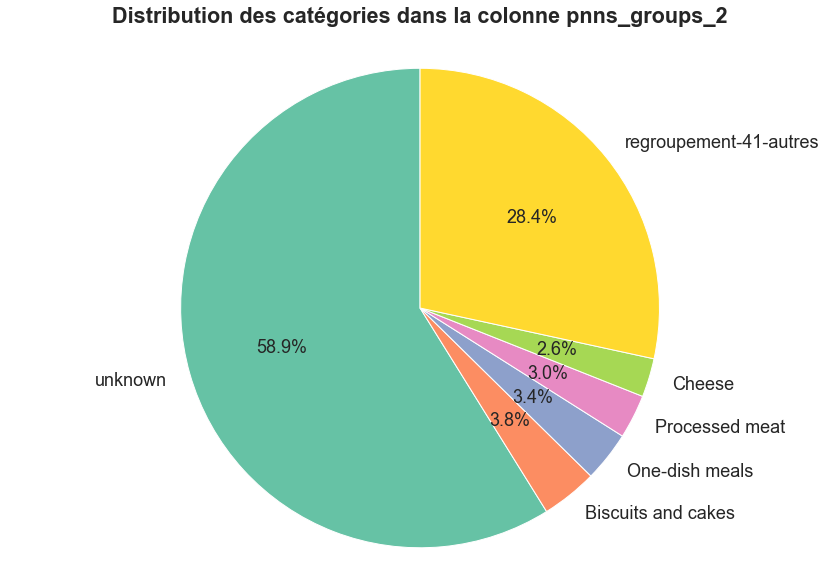

In [70]:
graph04 = sfg.MyGraph("Distribution des catégories dans la colonne pnns_groups_2")
graph04.add_pie(pnns_values_2.values, pnns_values_2.index)
fig, ax = graph04.fig, graph04.ax
save_fig("111_distribution_pnns_groups_2")
plt.show()

Les colonnes pnns_groups_1 et pnns_groups_2 ont des valeurs manquantes qui n'apparaissent pas en NaN mais qui ont la valeur 'unknown'. Elles ont plus de la moitié des données manquantes, contrairement à la première impression.  
Elles sont trop peu remplies pour me servir dans l'optique de mon application. 

**<font color=red>J'abandonne donc l'idée d'utiliser les colonnes de groupe pnns.</font>**

<a id='6_3'></a>

### 6.3. Doublon de variables : colonnes liées aux labels

J'ai le choix entre 3 colonnes pour les labels : labels, labels_tags et labels_en. Pour mon application, je cherche en particulier les produits bio.

**Nombre de données manquantes**

In [71]:
col_analysis = ["labels","labels_tags","labels_en"]
data[col_analysis].isna().sum()

labels         351687
labels_tags    351662
labels_en      351662
dtype: int64

In [72]:
data[col_analysis].isna().sum(axis=1).unique()

array([3, 0, 2, 1], dtype=int64)

Les colonnes labels_tags et labels_en ont légèrement moins de données manquantes que la colonne labels.  
Les 3 colonnes ne sont pas toujours remplies pour les mêmes lignes.

**Données contenues dans les colonnes labels**

In [73]:
data[col_analysis].dropna(how='all').head(10)

,labels,labels_tags,labels_en
code,,,
0000000000100,Delois france,fr:delois-france,fr:delois-france
000000000114,en:made-in-france,en:made-in-france,Made in France
000000000429,en:organic,en:organic,Organic
0000000014595,"Bio, Bio européen, Agriculture UE/Non UE, FR-B...","en:organic,en:eu-organic,en:eu-non-eu-agricult...","Organic,EU Organic,EU/non-EU Agriculture,FR-BI..."
0000000020114,Fabriqué en France,en:made-in-france,Made in France
000000002401,"Organic, fr:ab-agriculture-biologique","en:organic,en:eu-organic,fr:ab-agriculture-bio...","Organic,EU Organic,fr:ab-agriculture-biologique"
000000002946,en:palm-oil-free,en:palm-oil-free,Palm oil free
0000000034791,Organic,en:organic,Organic
0000000274722,"Viande Française, Fabriqué en France","fr:viande-francaise,en:made-in-france","fr:viande-francaise,Made in France"


**Nombre de données avec le label 'bio' ou 'organic'**

Pour mon application, ce sont les labels 'bio' ou 'organic' qui m'intéressent. Je regarde le nombre de lignes où l'un de ces labels apparaît. Pour simplifier l'analyse, je ne garde que la mention 'organic' lorsque 'bio' ou 'organic' apparaît.

In [74]:
bio_analysis = data[col_analysis].copy()
nb_bio = pd.DataFrame(columns=col_analysis)
for col in col_analysis:
    check_bio = bio_analysis[col].str.contains("bio", case=False, regex=False, na=False) | \
                bio_analysis[col].str.contains("organic", case=False, regex=False, na=False)
    bio_analysis.loc[check_bio, col] = "organic"
    nb_bio[col] = check_bio

In [75]:
nb_bio.sum()

labels         59559
labels_tags    60672
labels_en      60672
dtype: int64

In [76]:
nb_bio.sum(axis=1).unique()

array([0, 3, 2], dtype=int64)

In [77]:
len(nb_bio[nb_bio.labels & ((nb_bio.labels_tags==False) | (nb_bio.labels_en==False))])

0

Il y a plus de lignes avec des labels bio dans les colonnes labels_tags et labels_en que dans la colonne labels. La colonne labels ne comprend jamais de label bio lorsque labels_tags ou labels_en n'en contiennent pas.  
Les colonnes labels_tags et labels_en sont équivalentes : elles ont des labels bio sur les mêmes lignes. Seul leur formatage est différent. **Je privilégie labels_tags dont le formattage est universel.**

**Distribution des labels selon les colonnes**

In [78]:
labels_values = bio_analysis.labels.value_counts()
len(labels_values)

22863

In [79]:
labels_values_tags = bio_analysis.labels_tags.value_counts()
len(labels_values_tags)

17673

In [80]:
labels_values_en = bio_analysis.labels_en.value_counts()
len(labels_values_en)

17673

In [81]:
labels_values_tags[:10]

organic                                60672
en:gluten-free                          9695
en:made-in-france                       8749
en:green-dot                            5322
en:no-preservatives                     5028
en:no-colorings,en:no-preservatives     3438
en:no-colorings                         3385
en:vegetarian,en:vegan                  2771
en:no-added-sugar                       2164
en:made-in-italy                        2093
Name: labels_tags, dtype: int64

Il y a beaucoup de labels autres que biologique. Seule l'appartenance à un label bio m'intéresse. Par conséquent, **je crée une variable booléenne qui indique si un produit est bio ou non**. Puis je peux supprimer les colonnes de labels.

In [82]:
def add_is_bio_column(df):
    check_bio = df["labels_tags"].str.contains("bio", case=False, regex=False, na=False) | \
                df["labels_tags"].str.contains("organic", case=False, regex=False, na=False)
    df["is_bio"] = check_bio
    return df
data = add_is_bio_column(data)

Je regarde la distribution des produits estampillés bio et des autres.

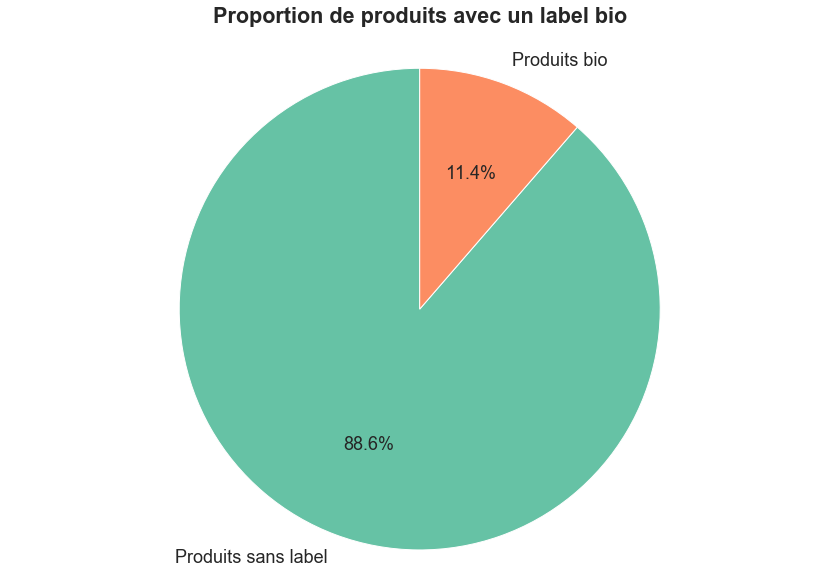

In [83]:
is_bio_values = data.is_bio.value_counts()
graph05 = sfg.MyGraph("Proportion de produits avec un label bio")
graph05.add_pie(is_bio_values.values, labels=["Produits sans label","Produits bio"])
fig, ax = graph05.fig, graph05.ax
save_fig("112_proportion_produits_bio")
plt.show()

Un peu plus de 11% des produits dans la base de données sont estampillés bio.

**<font color=red>Je supprime les colonnes labels, qui ne m'intéressent plus. Je conserve la colonne booléenne is_bio que je viens de créer.</font>**

<a id='6_4'></a>

### 6.4. Doublon de variables : colonnes liées au nutriscore et au nutrigrade

J'ai le choix entre 2 colonnes pour les nutriscores qui vont servir de référence au modèle de mon application : nutrition-score-fr_100g et nutriscore_score.  
Je les compare avec nutriscore_grade qui est la catégorisation des produits en fonction du nutriscore.

**Nombre de données manquantes**

In [84]:
col_analysis = ["nutrition-score-fr_100g", "nutriscore_score", "nutriscore_grade"]
data[col_analysis].isna().sum()

nutrition-score-fr_100g    306196
nutriscore_score           306197
nutriscore_grade           306197
dtype: int64

In [85]:
data[col_analysis].isna().sum(axis=1).unique()

array([3, 0, 2], dtype=int64)

In [86]:
len(data[data["nutrition-score-fr_100g"].isna() & (data["nutriscore_score"].notna() | data["nutriscore_grade"].notna())])

0

Il y a une donnée manquante en moins dans la colonne "nutrition-score-fr_100g". Aucune donnée manquante de la colonne "nutrition-score-fr_100g" n'est disponible dans les deux autres colonnes.

In [87]:
len(data[data["nutrition-score-fr_100g"].notna() & (data["nutriscore_score"].isna() | data["nutriscore_grade"].isna())])

1

Il manque la même ligne supplémentaire dans les colonnes "nutriscore_score" et "nutriscore_grade".

**Comparaison des données des deux colonnes de score**

Je compare les valeurs présentes dans les deux colonnes pour voir s'il y a une différence d'échelle ou si des valeurs semblent aberrantes dans l'une des colonnes.

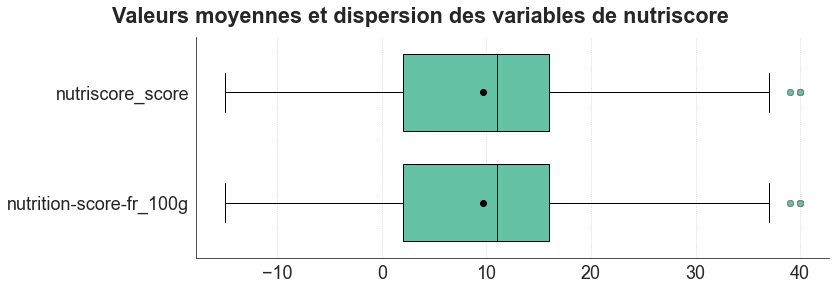

In [88]:
graph = sfg.MyGraph("Valeurs moyennes et dispersion des variables de nutriscore", figsize=(12,4))
graph.add_boxplot([data["nutrition-score-fr_100g"].dropna(),data["nutriscore_score"].dropna()], 
                  cat_labels=["nutrition-score-fr_100g","nutriscore_score"], means=True, vertical=False)
fig, ax = graph.fig, graph.ax
save_fig("113_boxplot_nutriscore")
plt.show()

Les notes sont similaires pour les deux séries. Je peux choisir indifféremment l'une ou l'autre variable.  
**<font color=red>Pour avoir un grade correspondant à chaque score, je garde les colonnes "nutriscore_score" et "nutriscore_grade".</font>**

<a id='6_5'></a>

### 6.5. Doublon de variables : colonnes liées à l'énergie

3 colonnes comportent des données liées à l'énergie pour 100g d'aliments : energy_100g, energy-kcal_100g et energy-kj_100g. Je dois n'en sélectionner qu'une, et éventuellement la compléter à l'aide des deux autres.

#### 6.5.1. Nombre de données manquantes

In [89]:
col_analysis = ["energy_100g","energy-kcal_100g","energy-kj_100g"]
data[col_analysis].isna().sum()

energy_100g            463
energy-kcal_100g     44319
energy-kj_100g      474790
dtype: int64

In [90]:
data[col_analysis].notna().sum()

energy_100g         533122
energy-kcal_100g    489266
energy-kj_100g       58795
dtype: int64

In [91]:
data[col_analysis].isna().sum(axis=1).unique()

array([1, 0, 3, 2], dtype=int64)

Il n'y a quasiment aucune valeur manquante dans la colonne energy_100g, que je privilégie donc par rapport aux deux autres colonnes.

La colonne energy-kcal_100g est bien plus souvent remplie que la colonne energy-kj_100g.

J'analyse si les données manquantes de la colonne energy_100g peuvent être renseignées à l'aide des deux autres colonnes.

In [92]:
len(data[data["energy_100g"].isna() & (data["energy-kcal_100g"].notna() | data["energy-kj_100g"].notna())])

0

Il n'y a aucune ligne où je dispose de données pour energy-kcal_100g ou energy-kj_100g quand energy_100g n'est pas renseigné.

#### 6.5.2. Vérification de l'unité des colonnes energy_100g, energy-kcal_100g et energy-kj_100g

Je vérifie dans quelle unité est exprimée la colonne energy_100g. Pour rappel, 1 kcal = 4,1868 kJ.

Un rapide sondage de comparaison des étiquettes des valeurs nutritionnelles et des informations contenues dans les colonnes energy_100g, energy-kcal_100g et energy-kj_100g montre que **toutes les données relatives à l'énergie sont enregistrées en kilo-joules, même dans la catégorie energy-kcal_100g**, avec parfois des petites différences de saisie ou de traitement (écart de 1 unité entre les kcal et les kj par exemple).

De ce fait, le ratio entre les différentes colonnes devrait être égal à 1.

In [93]:
verif_ratio = data[col_analysis].copy()
verif_ratio["ratio_energy_kcal"] = verif_ratio.energy_100g / verif_ratio["energy-kcal_100g"]
verif_ratio["ratio_energy_kj"] = verif_ratio.energy_100g / verif_ratio["energy-kj_100g"]
verif_ratio["ratio_kcal_kj"] = verif_ratio["energy-kcal_100g"] / verif_ratio["energy-kj_100g"]
verif_ratio[["ratio_energy_kcal","ratio_energy_kj","ratio_kcal_kj"]].describe()

,ratio_energy_kcal,ratio_energy_kj,ratio_kcal_kj
count,4.781050e+05,58645.000000,15076.000000
mean,inf,1.000000,1.041245
std,NaN,0.000036,0.762514
min,5.603448e-02,0.991196,0.000000
25%,1.000000e+00,1.000000,0.990805
50%,1.000000e+00,1.000000,0.999064
75%,1.000000e+00,1.000000,1.005269
max,inf,1.000000,17.846154


Lorsque les données en kj sont renseignées, les données de la colonne energy sont bien en kilo-joules, à 1% près (ratio de conversion compris entre 0,99 et 1.00).

In [94]:
verif_ratio[verif_ratio["ratio_energy_kj"]<1.0]

,energy_100g,energy-kcal_100g,energy-kj_100g,ratio_energy_kcal,ratio_energy_kj,ratio_kcal_kj
code,,,,,,
888707,1351.0,1351.0,1363.0,1.0,0.991196,0.991196


In [95]:
Image(url=data.loc["888707","image_nutrition_url"])

Il n'y a qu'une erreur, où energy-kj_100g est correct et l'erreur vient de energy_100g.

Je vérifie le ratio de conversion entre energy-kcal_100g et energy_100g lorsque energy-kj_100g n'est pas disponible.

In [96]:
verif_ratio[verif_ratio["energy-kj_100g"].isna()].ratio_energy_kcal.describe()

count    463029.0
mean          1.0
std           0.0
min           1.0
25%           1.0
50%           1.0
75%           1.0
max           1.0
Name: ratio_energy_kcal, dtype: float64

Lorsque les données en kj ne sont pas renseignées, les données de la colonne energy sont cohérentes avec celles de la colonne en kcal (ratio de conversion égal à 1 pour toutes les lignes). A garder en mémoire : malgré l'appellation de la colonne, les données de 'energy-kcal_100g' sont exprimées en kilo-joules.

#### 6.5.3. Vérification de la cohérence des valeurs de la colonne energy_100g

Etant donné que :
- les données de la colonne energy_100g sont exprimées en kilo-joules ;
- un gramme de fibre fournit 8 kJ (ou 1,9 kcal) ;
- un gramme de glucide ou de protéine fournit 17 kJ (ou 4 kcal) ;
- un gramme de lipide fournit 38 kJ (ou 9 kcal) ;
  
100g d'un produit ne peuvent pas fournir plus 3800 kJ (cas où le produit n'est composé que de lipides).

In [97]:
len(data[data.energy_100g > 3800.0])

1224

Il y a 1224 valeurs supérieures à 3800 kJ, donc aberrantes, pour la colonne energy_100g.

Ces valeurs supérieures à 3800 kJ sont-elles dues à une erreur de saisie basée sur des valeurs par portion plutôt que par 100g ? Si c'est le cas, les portions concernées (serving quantity) doivent être supérieures à 100g

In [98]:
data[data.energy_100g > 3800.0].serving_quantity.describe()

count      89.000000
mean      121.135393
std       178.393079
min         0.000000
25%        27.000000
50%       100.000000
75%       100.000000
max      1000.000000
Name: serving_quantity, dtype: float64

Sur les 1224 enregistrements concernés, seuls 89 ont une quantité de portion renseignée. Sur ces 89 lignes, plus des trois-quarts ont une quantité de portion inférieure à 100g. Les valeurs énergétiques supérieures à 3800 kJ ne s'expliquent donc pas par une erreur de saisie basée sur une saisie basée sur des portions supérieures à 100g.

**<font color=red>Je supprime les enregistrements dont la valeur énergétique est supérieure à 3800 kJ.</font>**

#### 6.5.4. Traitement sur la colonne energy_100g

In [99]:
avant_traitement = data[["energy_100g"]].copy()

In [100]:
def remove_energy_outliers(df):
    index_to_check = list(df[df["energy-kj_100g"].notna()].index)
    if index_to_check:
        df.loc[index_to_check,"energy_100g"] = df.loc[index_to_check,"energy-kj_100g"]
    index_to_check = list(df[df["energy-kj_100g"].isna() & df["energy-kcal_100g"].notna()].index)
    if index_to_check:
        df.loc[index_to_check,"energy_100g"] = df.loc[index_to_check,"energy-kcal_100g"]
    index_to_drop = list(df[df.energy_100g > 3800.0].index)
    if index_to_drop:
        df.drop(index_to_drop, inplace=True)
    return df

In [101]:
data = remove_energy_outliers(data)

#### 6.5.5. Comparaison des valeurs centrales et de dispersion avant et après traitement

In [102]:
check_values = [avant_traitement.energy_100g.dropna(), data.energy_100g.dropna()]

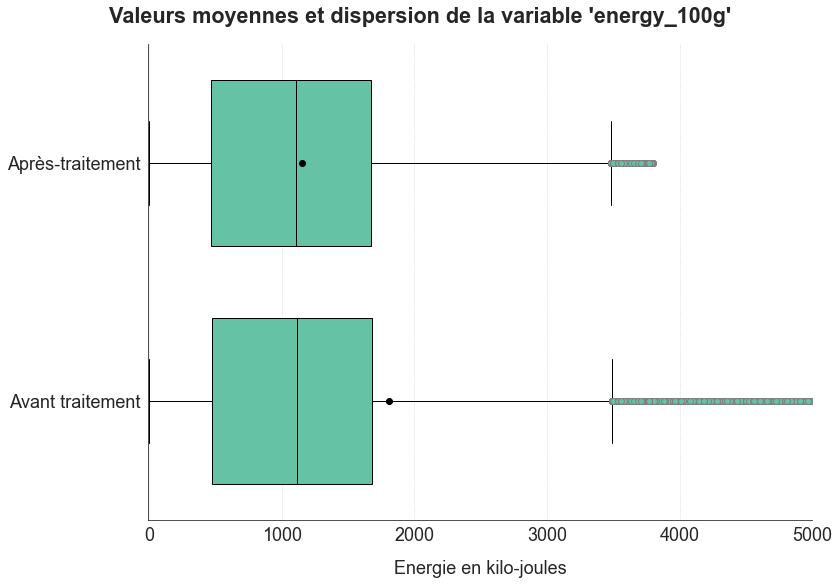

In [103]:
graph = sfg.MyGraph("Valeurs moyennes et dispersion de la variable 'energy_100g'")
graph.add_boxplot(check_values, cat_labels=["Avant traitement","Après-traitement"], means=True, vertical=False)
graph.set_axe_x(label="Energie en kilo-joules", tick_min=-10, tick_max=5000)
fig, ax = graph.fig, graph.ax
save_fig("114_boxplot_traitement_energy")
plt.show()

**<font color=red>Je conserve la colonne energy_100g</font>** qui n'a quasiment aucune valeur manquante et qui est cohérente avec les autres colonnes.

<a id='6_6'></a>

### 6.6. Doublon de variables : choix entre le sel et le sodium

Les variables salt_100g et sodium_100g sont en doublon. Je peux donc n'en conserver qu'une seule.  
Pour rappel, la teneur en sel peut être obtenue en multipliant par 2,54 la teneur en sodium. Référence : https://www.cerin.org/glossaire/sel-chlorure-de-sodium/

#### 6.6.1. Nombre de données manquantes

In [104]:
col_analysis = ["salt_100g","sodium_100g"]
data[col_analysis].isna().sum()

salt_100g      16846
sodium_100g    16849
dtype: int64

In [105]:
data[col_analysis].isna().sum(axis=1).unique()

array([0, 2, 1], dtype=int64)

Il y a à peu près autant de données manquantes dans les deux colonnes. Voyons si l'on compléter la colonne salt_100g à partir de sodium_100g.

In [106]:
len(data[data.salt_100g.isna() & data.sodium_100g.notna()])

0

Lorsque salt_100g n'est pas renseigné, sodium_100g ne l'est pas non plus.

**Je conserve donc la seule colonne salt_100g.**

#### 6.6.2. Vérification des valeurs égales à 0 sur la colonne salt_100g

Je vérifie s'il y a des lignes où la teneur en sel est indiquée à 0 et où celle en sodium est différente de 0.

In [107]:
data[(data.salt_100g==0.0) & (data.sodium_100g!=0.0)][["salt_100g","sodium_100g"]]

,salt_100g,sodium_100g
code,,
0014113911658,0.0,0.004
3250391100675,0.0,NaN
3292090000269,0.0,0.004
3350030216412,0.0,0.040
3538280839333,0.0,NaN
3760121211286,0.0,0.004
4260044260228,0.0,0.080
7896496971831,0.0,0.048


<font color=red>Pour ces lignes, je peux renseigner la teneur en sel à partir de celle en sodium, en multipliant par 2,54 la teneur en sodium</font>. Référence : https://www.cerin.org/glossaire/sel-chlorure-de-sodium/

In [108]:
def add_salt_from_sodium(df):
    index_to_change = list(df[(df.salt_100g==0.0) & (df.sodium_100g!=0.0) & (df.sodium_100g.notna())].index)
    if index_to_change:
        df.loc[index_to_change,"salt_100g"] = df.loc[index_to_change,"sodium_100g"] * 2.54
    return df

In [109]:
data = add_salt_from_sodium(data)

#### 6.6.3. Vérification du ratio entre le sel et le sodium

Pour rappel, le ratio de conversion entre le sel et le sodium est de 2,54.

In [110]:
verif_ratio = data[data.salt_100g.notna() & data.sodium_100g.notna() & (data.sodium_100g!=0.0)][["salt_100g","sodium_100g"]]
verif_ratio["ratio"] = verif_ratio.salt_100g / verif_ratio.sodium_100g
verif_ratio.ratio.describe()

count    458674.000000
mean          2.500286
std           0.108729
min           0.002500
25%           2.500000
50%           2.500000
75%           2.500000
max          60.536667
Name: ratio, dtype: float64

In [111]:
index_to_check = verif_ratio[(verif_ratio.ratio<2.4) | (verif_ratio.ratio>2.6)].index
len(index_to_check)

37

La plupart du temps, le ratio de conversion utilisé par OpenFactFoods est égal à 2,5.  
Il y a 37 enregistrements où le ratio entre le sel et le sodium est inférieur à 2,4 ou supérieur à 2,6.

In [112]:
url_images = data.loc[index_to_check].image_nutrition_url
url_images.dropna(inplace=True)
len(url_images)

30

Sur ces 37 enregistrements, 30 disposent de la photo de l'étiquette des valeurs nutritionnelles.  
Comme il n'y a pas beaucoup de lignes concernées, je vérifie au cas par cas l'origine de l'erreur du ratio, pour en déduire une règle de traitement de ces erreurs.

**Analyse des 30 étiquettes de valeurs nutritionnelles**

In [113]:
idx_image = 0
print(verif_ratio.loc[url_images.index[idx_image]])
Image(url=url_images.iloc[idx_image])

salt_100g      0.00018
sodium_100g    0.07200
ratio          0.00250
Name: 26037318, dtype: float64


Ratio = 0,0025  
Teneur en sel erronée (problème d'unité) : multiplier par 1000 = 0,18  
Vrai ratio = 2,5

In [114]:
idx_image = 1
print(verif_ratio.loc[url_images.index[idx_image]])
Image(url=url_images.iloc[idx_image])

salt_100g       0.124968
sodium_100g    49.987200
ratio           0.002500
Name: 3023291267034, dtype: float64


Ratio = 0,0025  
Teneur en sel ok  
Teneur en sodium erronée (problème d'unité) : 0,0492  
Vrai ratio = 2,54

In [115]:
idx_image = 2
print(verif_ratio.loc[url_images.index[idx_image]])
Image(url=url_images.iloc[idx_image])

salt_100g      2.8
sodium_100g    1.0
ratio          2.8
Name: 3095755156017, dtype: float64


Ratio = 2,8  
Teneur en sel erronée (problème de saisie) : 2,5  
Vrai ratio = 2,5

In [116]:
idx_image = 3
print(verif_ratio.loc[url_images.index[idx_image]])
Image(url=url_images.iloc[idx_image])

salt_100g      0.00059
sodium_100g    0.23600
ratio          0.00250
Name: 3175681797437, dtype: float64


Ratio = 0,0025  
Teneur en sel erronée (problème d'unité) : à multiplier par 1000 = 0,59  
Vrai ratio = 2,5

In [117]:
idx_image = 4
print(verif_ratio.loc[url_images.index[idx_image]])
Image(url=url_images.iloc[idx_image])

salt_100g      0.002413
sodium_100g    0.380000
ratio          0.006350
Name: 3179732324818, dtype: float64


Ratio = 0,00635  
Teneur en sel erronée (problème d'unité) = 0.02413  
Teneur en sodium erronée (erreur de saisie) = 0.0095
Vrai ratio = 2,54

In [118]:
idx_image = 5
print(verif_ratio.loc[url_images.index[idx_image]])
Image(url=url_images.iloc[idx_image])

salt_100g      0.00018
sodium_100g    0.07200
ratio          0.00250
Name: 3245412478864, dtype: float64


Ratio = 0,0025  
Teneur en sel erronée (problème d'unité) : à multiplier par 1000 = 0,18  
Vrai ratio = 2,5

In [119]:
idx_image = 6
print(verif_ratio.loc[url_images.index[idx_image]])
Image(url=url_images.iloc[idx_image])

salt_100g      0.00001
sodium_100g    0.00400
ratio          0.00250
Name: 3250391458851, dtype: float64


Ratio = 0,0025  
Teneur en sel erronée (problème d'unité) : à multiplier par 1000 = 0,01  
Vrai ratio = 2,5

In [120]:
idx_image = 7
print(verif_ratio.loc[url_images.index[idx_image]])
Image(url=url_images.iloc[idx_image])

salt_100g      2.05
sodium_100g    1.00
ratio          2.05
Name: 3250392105655, dtype: float64


Ratio = 2,05  
Teneur en sel ok  
La teneur en sodium doit être erronée  
Vrai ratio = ?

In [121]:
idx_image = 8
print(verif_ratio.loc[url_images.index[idx_image]])
Image(url=url_images.iloc[idx_image])

salt_100g      1.10
sodium_100g    0.40
ratio          2.75
Name: 3263852911710, dtype: float64


Ratio = 2,75  
Teneur en sel ok.  
La teneur en sodium doit être erronée.  
Vrai ratio = ?

In [122]:
idx_image = 9
print(verif_ratio.loc[url_images.index[idx_image]])
Image(url=url_images.iloc[idx_image])

salt_100g      2.000000
sodium_100g    1.160000
ratio          1.724138
Name: 3273120019635, dtype: float64


Ratio = 1,72414  
Teneur en sel ok  
Teneur en sodium erronée  
Vrai ratio = ?

In [123]:
idx_image = 10
print(verif_ratio.loc[url_images.index[idx_image]])
Image(url=url_images.iloc[idx_image])

salt_100g      0.00762
sodium_100g    0.00320
ratio          2.38125
Name: 3274936001210, dtype: float64


Ratio = 2,38125  
Teneur en sel ok  
Teneur en sodium erronée (problème de saisie) : 0,003  
Vrai ratio = 2,54

In [124]:
idx_image = 11
print(verif_ratio.loc[url_images.index[idx_image]])
Image(url=url_images.iloc[idx_image])

salt_100g      2.997200
sodium_100g    1.020000
ratio          2.938431
Name: 3278310001278, dtype: float64


In [125]:
Image(url=data.loc[url_images.index[idx_image]].image_url)

Ratio = 2,938431  
Teneur en sel ok  
Teneur en sodium erronée  
Vrai ratio = ?

In [126]:
idx_image = 12
print(verif_ratio.loc[url_images.index[idx_image]])
Image(url=url_images.iloc[idx_image])

salt_100g       0.0300
sodium_100g     0.0012
ratio          25.0000
Name: 3288131500577, dtype: float64


Ratio = 25  
Teneur en sel ok  
Teneur en sodium erronée (problème d'unité) : à multiplier par 10 = 0,012  
Vrai ratio = 2,5

In [127]:
idx_image = 13
print(verif_ratio.loc[url_images.index[idx_image]])
Image(url=url_images.iloc[idx_image])

salt_100g      0.600
sodium_100g    0.320
ratio          1.875
Name: 3302747087021, dtype: float64


Ratio = 1,875  
Teneur en sel ok  
Teneur en sodium erronée  
Vrai ratio = ?

In [128]:
idx_image = 14
print(verif_ratio.loc[url_images.index[idx_image]])
Image(url=url_images.iloc[idx_image])

salt_100g      0.080000
sodium_100g    0.013200
ratio          6.060606
Name: 3353930000136, dtype: float64


Ratio = 6,06061  
Teneur en sel ok  
Teneur en sodium erronée  
Vrai ratio = ?

In [129]:
idx_image = 15
print(verif_ratio.loc[url_images.index[idx_image]])
Image(url=url_images.iloc[idx_image])

salt_100g      5.511800
sodium_100g    2.576000
ratio          2.139674
Name: 3390390002188, dtype: float64


Ratio = 2,13967  
Teneur en sel ok  
Teneur en sodium erronée (problème de saisie) = 2,17  
Vrai ratio = 2,54

In [130]:
idx_image = 16
print(verif_ratio.loc[url_images.index[idx_image]])
Image(url=url_images.iloc[idx_image])

salt_100g      0.508000
sodium_100g    0.212000
ratio          2.396226
Name: 3396411225024, dtype: float64


Ratio = 2,39623  
Teneur en sel légèrement erronée (problème de saisie) = 0,53  
Vrai ratio = 2,5

In [131]:
idx_image = 17
print(verif_ratio.loc[url_images.index[idx_image]])
Image(url=url_images.iloc[idx_image])

salt_100g       0.100
sodium_100g     0.004
ratio          25.000
Name: 3502110008244, dtype: float64


Ratio = 25  
Teneur en sel erronée (problème d'unité) : à diviser par 10 = 0,01  
Vrai ratio = 2,5

In [132]:
idx_image = 18
print(verif_ratio.loc[url_images.index[idx_image]])
Image(url=url_images.iloc[idx_image])

salt_100g      4.100000
sodium_100g    1.920000
ratio          2.135417
Name: 3560070824885, dtype: float64


In [133]:
data.loc[url_images.index[idx_image]][["proteins_100g", "fat_100g", "carbohydrates_100g", "salt_100g", "fiber_100g",
            "saturated-fat_100g", "sugars_100g", "energy_100g"]]

proteins_100g           11
fat_100g                16
carbohydrates_100g      53
salt_100g              4.1
fiber_100g               0
saturated-fat_100g     9.1
sugars_100g             62
energy_100g           1920
Name: 3560070824885, dtype: object

Ratio = 2,13542  
Teneur en sel erronée : problème de saisie car indiqué pour 485g -> toutes les valeurs sont erronées. Enregistrement à supprimer.  
Teneur en sodium ?  
Vrai ratio = ?

In [134]:
idx_image = 19
print(verif_ratio.loc[url_images.index[idx_image]])
Image(url=url_images.iloc[idx_image])

salt_100g       2.032000
sodium_100g     0.088000
ratio          23.090909
Name: 3560071008109, dtype: float64


Ratio = 23,0909  
Teneur en sel erronée (problème de saisie) = 0,22 (peut être approximée en divisant par 10 la teneur en sel)  
Vrai ratio = 2,5

In [135]:
idx_image = 20
print(verif_ratio.loc[url_images.index[idx_image]])
Image(url=url_images.iloc[idx_image])

salt_100g       1.778000
sodium_100g     0.072000
ratio          24.694444
Name: 3660140919050, dtype: float64


Ratio = 24,6944  
Teneur en sel erronée (problème de saisie) = 0,18 (peut être approximée en divisant par 10 la teneur en sel)  
Vrai ratio = 2,5

In [136]:
idx_image = 21
print(verif_ratio.loc[url_images.index[idx_image]])
Image(url=url_images.iloc[idx_image])

salt_100g      1.600000
sodium_100g    0.520000
ratio          3.076923
Name: 3700009261033, dtype: float64


Ratio = 3,07692  
Teneur en sel ok  
Teneur en sodium erronée  
Vrai ratio = ?

In [137]:
idx_image = 22
print(verif_ratio.loc[url_images.index[idx_image]])
Image(url=url_images.iloc[idx_image])

salt_100g      0.43688
sodium_100g    3.32000
ratio          0.13159
Name: 3700029201880, dtype: float64


Ratio = 0,13159  
Teneur en sel ok  
Teneur en sodium erronée (problème de saisie) = 0,172  
Vrai ratio = 2,54

In [138]:
idx_image = 23
print(verif_ratio.loc[url_images.index[idx_image]])
Image(url=url_images.iloc[idx_image])

salt_100g      0.610000
sodium_100g    0.216000
ratio          2.824074
Name: 3760121211545, dtype: float64


Ratio = 2,82407  
Teneur en sel ok  
Teneur en sodium erronée  
Vrai ratio = ?

In [139]:
idx_image = 24
print(verif_ratio.loc[url_images.index[idx_image]])
Image(url=url_images.iloc[idx_image])

salt_100g      1.270
sodium_100g    0.400
ratio          3.175
Name: 3760262990002, dtype: float64


Ratio = 3,175  
Teneur en sel erronée (problème de saisie) : <= 1g = 1  
Vrai ratio = 2,5

In [140]:
idx_image = 25
print(verif_ratio.loc[url_images.index[idx_image]])
Image(url=url_images.iloc[idx_image])

salt_100g      0.76200
sodium_100g    0.32000
ratio          2.38125
Name: 5410068237501, dtype: float64


Ratio = 2,38125  
Teneur en sel ok  
Teneur en sodium erronée (problème de saisie) = 0,3  
Vrai ratio = 2,54

In [141]:
idx_image = 26
print(verif_ratio.loc[url_images.index[idx_image]])
Image(url=url_images.iloc[idx_image])

salt_100g      0.013000
sodium_100g    0.124800
ratio          0.104167
Name: 7290013380845, dtype: float64


Ratio = 0,104167  
Teneur en sel erroné (problème saisie) = 0.78  
Teneur en sodium erronée  
Vrai ratio = ?

In [142]:
idx_image = 27
print(verif_ratio.loc[url_images.index[idx_image]])
Image(url=url_images.iloc[idx_image])

salt_100g      0.070000
sodium_100g    0.030961
ratio          2.260883
Name: 7616600712699, dtype: float64


Ratio = 2,26088  
Teneur en sel ok  
Teneur en sodium erronée  
Vrai ratio = ?

In [143]:
idx_image = 28
print(verif_ratio.loc[url_images.index[idx_image]])
Image(url=url_images.iloc[idx_image])

salt_100g      2.5908
sodium_100g    0.4080
ratio          6.3500
Name: 7750243030328, dtype: float64


Ratio = 6,35  
Teneur en sel ok  
Teneur en sodium (sodio en espagnol) erronée (problème de saisie) = 1,02  
Vrai ratio = 2,54

In [144]:
idx_image = 29
print(verif_ratio.loc[url_images.index[idx_image]])
Image(url=url_images.iloc[idx_image])

salt_100g      0.000005
sodium_100g    0.002000
ratio          0.002500
Name: 8015602000435, dtype: float64


Ratio = 0,0025  
Teneur en sel erronée (problème d'unité') : multiplier par 1000 = 0,005  
Vrai ratio = 2,5

**Résumé de l'étude sur les 30 cas où le ratio est <2.4 ou >2.6 avec une étiquette**

Cas selon la valeur du ratio :
- 0,0025 : 6 cas. 5 cas où la teneur en sel est fausse, à cause d'un problème d'unité (teneur en sel à multiplier par 1000). 1 cas où la teneur en sel est correcte : le problème vient de l'unité de la teneur en sodium (code '3023291267034', changer préalablement la teneur en sodium pour avoir le bon ratio). Règle pour nouvelle erreur : multiplier par 1000 la teneur en sel.
- < 2 (mais différent de 0,0025 ou >=0.003) : 5 cas. 3 cas où la teneur en sel est correcte. 2 cas où la teneur en sel est fausse (changer la teneur en sel pour les codes '3179732324818' et '7290013380845'). Règle pour nouvelle erreur : conserver la teneur en sel.
- \>=2 et <=3 : 11 cas. 8 cas où la teneur en sel est correcte. 3 cas où la teneur en sel est fausse à cause d'une erreur de saisie (changer la teneur en sel pour les codes '3095755156017' et '3396411225024', supprimer le code '3560070824885'). Règle pour nouvelle erreur : conserver la teneur en sel.
- \>3 et <= 20 : 4 cas. 3 cas où la teneur en sel est correcte. 1 cas où la teneur en sel est fausse à cause d'une erreur de saisie (changer la teneur en sel pour le code '3760262990002'). Règle pour nouvelle erreur : conserver la teneur en sel.
- \>20 : 4 cas. 3 cas où la teneur en sel est erronée mais peut être obtenue ou approximée en divisant la teneur en sel par 10. 1 cas où la teneur en sel est correcte (teneur en sodium à modifier pour le code '3288131500577'). Règle pour nouvelle erreur : diviser par 10 la teneur en sel.

**Règle des traitements à appliquer**

Je déduis de mes observations ci-dessus le traitement à appliquer pour généraliser au mieux la correction des valeurs erronées sur le sel décelées à partir du ratio sel_100g / sodium_100g :
- effectuer les modifications sur la teneur en sel ou en sodium pour les codes listés ci-dessus (calculer l'autre valeur si nécessaire) ;
- calculer le ratio ;
- ne pas modifier la teneur en sel si le ratio est >=0.003 ou <=20 ;
- si le ratio est < 0,003 : on multiplie la teneur en sel par 1000 ;
- si le ratio est > 20 : on divise la teneur en sel par 10.

In [145]:
def check_salt_sodium_ratio(df):
    df.loc["3023291267034","sodium_100g"] = 0.0492
    df.loc["3179732324818","salt_100g"] = 0.02413
    df.loc["7290013380845","salt_100g"] = 0.78
    df.loc["3095755156017","salt_100g"] = 2.5
    df.loc["3396411225024","salt_100g"] = 0.53
    df.drop(["3560070824885"], inplace=True)
    df.loc["3760262990002","salt_100g"] = 1.0
    df.loc["3288131500577","sodium_100g"] = 0.012
    
    verif_ratio = df[df.salt_100g.notna() & df.sodium_100g.notna() & (df.sodium_100g!=0.0)][["salt_100g","sodium_100g"]]
    verif_ratio["ratio"] = verif_ratio.salt_100g / verif_ratio.sodium_100g
    verif_ratio = verif_ratio[(verif_ratio.ratio<0.003) | (verif_ratio.ratio>20)]
    for i, verif in verif_ratio.iterrows():
        if verif.ratio < 0.003:
            df.loc[i,"salt_100g"] *= 1000
        else:
            df.loc[i,"salt_100g"] /= 10
    return df

In [146]:
data = check_salt_sodium_ratio(data)

**<font color='red'>Après avoir corrigé les valeurs erronées sur la base du ratio sel/sodium, je conserve la colonne salt_100g et je supprime la colonne sodium_100g.</font>**

<a id='6_7'></a>

### 6.7. Projection sur les colonnes conservées pour l'application

<font color=red>En phase de production, toute l'analyse précédente sur les colonnes en doublon ne sera plus réalisée et les colonnes qui nous intéressent seront directement sélectionnées, après avoir apporter les corrections nécessaires.</font> Dans cette logique, je préfère projeter sur les colonnes utiles plutôt que de supprimer les colonnes que je n'utiliserai pas.

In [147]:
col_verif = ["image_nutrition_url", "serving_quantity"]
verif = data[col_verif].copy()

In [148]:
def project_columns_appli(df):
    col_appli = ["product_name", "image_url", 
                 "proteins_100g", "fat_100g", "carbohydrates_100g", "salt_100g", "fiber_100g",
                 "saturated-fat_100g", "sugars_100g", "energy_100g", "nutriscore_score", "nutriscore_grade",
                 "ingredients_from_palm_oil_n", "additives_n", "is_bio"]
    return df[col_appli]
data = project_columns_appli(data)

---
<a id='7_0'></a>

## <font color=blue>7. Vérification et traitement des données aberrantes</font>

### 7.1. Données numériques qui doivent être positives ou nulles

Les colonnes qui indiquent les macro-nutriments (et éventuellement leur sous-catégorie), l'énergie, les nombres d'additifs et les nombres d'ingrédients à base d'huile de palme doivent être positives.

In [149]:
col_num = ["proteins_100g", "fat_100g", "carbohydrates_100g", "salt_100g", "fiber_100g",
           "saturated-fat_100g", "sugars_100g", "energy_100g", "ingredients_from_palm_oil_n", "additives_n"]
for col in col_num:
    print("{} : {} valeurs négatives".format(col, len(data[data[col]<0.0])))

proteins_100g : 0 valeurs négatives
fat_100g : 0 valeurs négatives
carbohydrates_100g : 0 valeurs négatives
salt_100g : 0 valeurs négatives
fiber_100g : 0 valeurs négatives
saturated-fat_100g : 0 valeurs négatives
sugars_100g : 1 valeurs négatives
energy_100g : 0 valeurs négatives
ingredients_from_palm_oil_n : 0 valeurs négatives
additives_n : 0 valeurs négatives


In [150]:
index_to_check = data[data.sugars_100g < 0].index
print(data.loc[index_to_check].product_name.values)
data.loc[index_to_check][col_num]

['Caprice des dieux']


,proteins_100g,fat_100g,carbohydrates_100g,salt_100g,fiber_100g,saturated-fat_100g,sugars_100g,energy_100g,ingredients_from_palm_oil_n,additives_n
code,,,,,,,,,,
3161712000928,15.3,30.0,0.8,1.4,NaN,21.0,-0.1,1379.0,0.0,0.0


Voici l'image trouvée sur le site d'OpenFactFoods sur une autre page sur le caprice des dieux à l'adresse : https://fr.openfoodfacts.org/produit/3161716031003/caprice-des-dieux

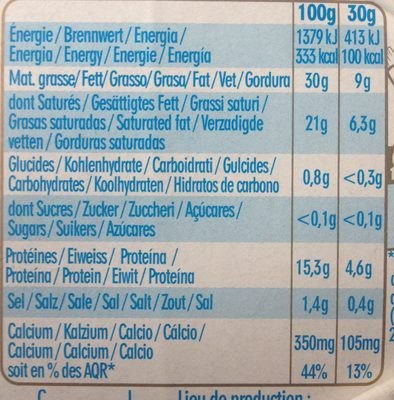

In [151]:
url="nutrition_caprice_des_dieux.jpg"
if IN_COLAB:
    url = PATH_DRIVE + "/" + url
Image(url)

Les sucres sont inférieurs à 0,1g mais non nuls. Le signe < a été interprété comme un signe négatif.

**Traitement**

Il y a très rarement des valeurs négatives. Toutefois, si une autre erreur se produit, je ne peux pas savoir si ce sera le même type d'erreur. <font color=red>Je supprime donc les enregistrements avec une valeur négative pour l'un de ces champs.</font>

In [152]:
def correct_negative_values(df):
    col_num = ["proteins_100g", "fat_100g", "carbohydrates_100g", "salt_100g", "fiber_100g",
               "saturated-fat_100g", "sugars_100g", "energy_100g", "ingredients_from_palm_oil_n", "additives_n"]
    for col in col_num:
        index_to_drop = list(df[df[col] < 0.0].index)
        if index_to_drop:
            df.drop(index_to_drop, inplace=True)
    return df

In [153]:
data = correct_negative_values(data)

<a id='7_2'></a>

### 7.2. Données numériques qui doivent être inférieures ou égales à 100

Les colonnes qui indiquent les macro-nutriments (et éventuellement leur sous-catégorie) sont exprimées en grammes pour 100g. Elles doivent donc être inférieures ou égales à 100.  
Attention, ce raisonnement ne vaut pas pour l'énergie qui est exprimée dans une autre unité (en kilo-joules).

In [154]:
col_num = ["proteins_100g", "fat_100g", "carbohydrates_100g", "salt_100g", "fiber_100g","saturated-fat_100g", "sugars_100g"]
for col in col_num:
    print("{} : {} valeurs supérieures à 100".format(col, len(data[data[col]>100.0])))

proteins_100g : 2 valeurs supérieures à 100
fat_100g : 4 valeurs supérieures à 100
carbohydrates_100g : 18 valeurs supérieures à 100
salt_100g : 19 valeurs supérieures à 100
fiber_100g : 9 valeurs supérieures à 100
saturated-fat_100g : 6 valeurs supérieures à 100
sugars_100g : 10 valeurs supérieures à 100


**Traitement**

<font color=red>Je supprime ces valeurs aberrantes.</font>

Remarque : dans le cadre d'une entreprise, j'analyserais les lignes avec ces valeurs aberrantes (car elles sont peu nombreuses) et/ou je ferais appel à l'avis d'un expert métier.

In [155]:
def correct_over100g_values(df):
    col_num = ["proteins_100g", "fat_100g", "carbohydrates_100g", "salt_100g", "fiber_100g",
               "saturated-fat_100g", "sugars_100g"]
    for col in col_num:
        index_to_drop = list(df[df[col] > 100.0].index)
        if index_to_drop:
            df.drop(index_to_drop, inplace=True)
    return df

In [156]:
data = correct_over100g_values(data)

<a id='7_3'></a>

### 7.3. Saturated-fat doit être inférieur ou égal à fat

La graisse saturée est une sous-catégorie de la graisse. Sa valeur ne peut donc pas excéder celle de la graisse.

In [157]:
len(data[data["saturated-fat_100g"] > data.fat_100g].index)

159

**Traitement**

<font color=red>Je supprime ces valeurs aberrantes.</font>

Remarque : dans le cadre d'une entreprise, j'analyserais les lignes avec ces valeurs aberrantes (car elles sont peu nombreuses) et/ou je ferais appel à l'avis d'un expert métier.

In [158]:
def correct_saturated_fat(df):
    index_to_drop = list(df[df["saturated-fat_100g"] > df.fat_100g].index)
    if index_to_drop:
        df.drop(index_to_drop, inplace=True)
    return df

In [159]:
data = correct_saturated_fat(data)

<a id='7_4'></a>

### 7.4. Sugars doit être inférieur ou égal à carbohydrates

Le sucre est une sous-catégorie des glucides. Sa valeur ne peut donc pas excéder celle des glucides.

In [160]:
len(data[data.sugars_100g > data.carbohydrates_100g].index)

144

**Traitement**

<font color=red>Je supprime ces valeurs aberrantes.</font>

Remarque : dans le cadre d'une entreprise, j'analyserais les lignes avec ces valeurs aberrantes (car elles sont peu nombreuses) et/ou je ferais appel à l'avis d'un expert métier.

In [161]:
def correct_sugars(df):
    index_to_drop = list(df[df.sugars_100g > df.carbohydrates_100g].index)
    if index_to_drop:
        df.drop(index_to_drop, inplace=True)
    return df

In [162]:
data = correct_sugars(data)

<a id='7_5'></a>

### 7.5. La somme des macro-nutriments doit être inférieure ou égale à 100g

La somme des macro-nutriments "proteins_100g", "fat_100g", "carbohydrates_100g", "salt_100g" et "fiber_100g" est exprimée en grammes pour 100g. Elle ne peut donc pas être supérieure à 100.

In [163]:
col_macro = ["proteins_100g","fat_100g","carbohydrates_100g","salt_100g","fiber_100g"]
verif_macro = data[col_macro].copy()
verif_macro["total_100g"] = verif_macro.sum(axis=1)
verif_macro["serving_quantity"] = verif.serving_quantity

len(verif_macro[verif_macro.total_100g > 100.0].index)

4680

**Traitement**

<font color=red>Je supprime ces valeurs aberrantes.</font>

Remarque : dans le cadre d'une entreprise, j'analyserais les lignes avec ces valeurs aberrantes et/ou je ferais appel à l'avis d'un expert métier.

In [164]:
def correct_sum_over100g(df):
    col_macro = ["proteins_100g","fat_100g","carbohydrates_100g","salt_100g","fiber_100g"]
    verif_macro = df[col_macro].copy()
    verif_macro["total_100g"] = verif_macro.sum(axis=1)
    index_to_drop = list(verif_macro[verif_macro.total_100g > 100.0].index)
    if index_to_drop:
        df.drop(index_to_drop, inplace=True)
    return df

In [165]:
data = correct_sum_over100g(data)

---
<a id='8_0'></a>

## <font color=blue>8. Traitement des valeurs manquantes</font>

### 8.1. Analyse des colonnes avec des valeurs manquantes

In [166]:
mydefault_plt_parameters()

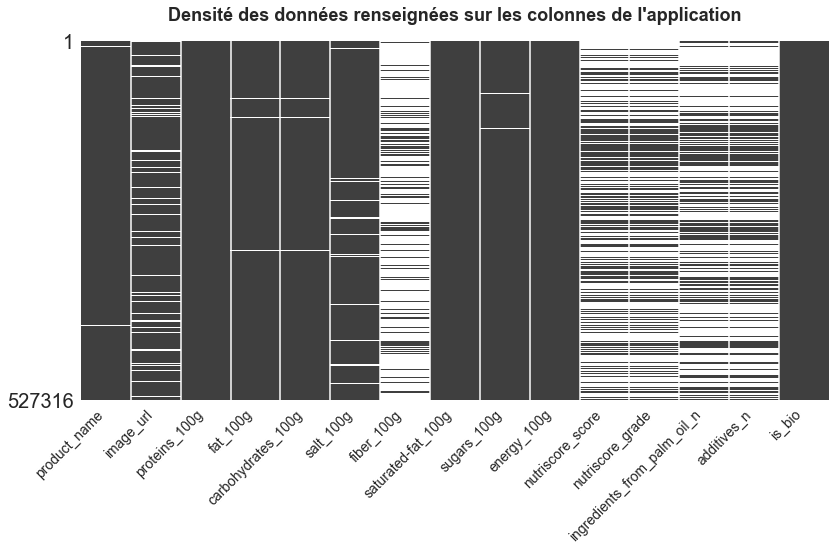

In [167]:
fig = plt.figure()
ax = plt.axes()
msno.matrix(data, sparkline=False, ax=ax)
ticklabels = ax.xaxis.get_ticklabels()
ax.xaxis.set_ticks_position('bottom')
ax.xaxis.set_ticks_position('none')
ax.set_xticklabels(ticklabels, rotation=45, ha='right', fontsize=14)
plt.title("Densité des données renseignées sur les colonnes de l'application", fontsize=18)
plt.tight_layout()
save_fig("115_densite_donnees_remplies_final")
plt.show()

In [168]:
percent_missing = pd.DataFrame((data.isna().sum() / len(data)), index=data.columns, columns=["percent"])
percent_missing.sort_values(by="percent", inplace=True)
percent_missing.head()

,percent
is_bio,0.000000
energy_100g,0.000857
proteins_100g,0.001464
product_name,0.002463
sugars_100g,0.003967


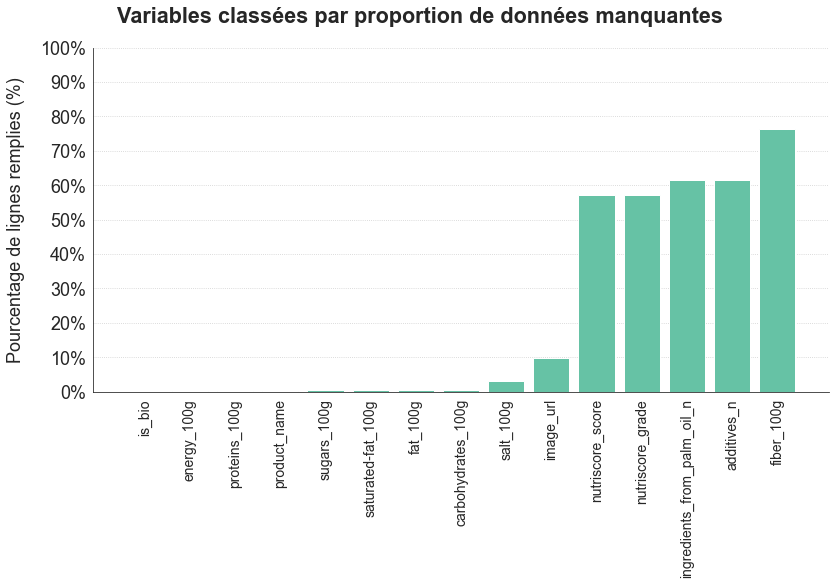

In [169]:
graph = sfg.MyGraph("Variables classées par proportion de données manquantes")
graph.add_barv(percent_missing.index, percent_missing.percent)
graph.set_axe_x(rotation=90)
graph.set_axe_y(label="Pourcentage de lignes remplies (%)", tick_min=0, tick_max=1.0, tick_step=0.1, tick_labels_format=':.0%')
fig, ax = graph.fig, graph.ax
ax[0].tick_params(axis="x", labelsize=14)
save_fig("116_classement_donnees_manquantes_final")
plt.show()

**Colonnes fiber_100g, additives_n et ingredients_from_palm_oil_n**

Ces trois colonnes ont plus de 60% de données manquantes.  
Tous les aliments ne contiennent pas des additifs ou des ingrédients issus de l'huile de palme. Les autres colonnes ne me sont d'aucune aide pour imputer leur valeur. Aussi, je conserve ces deux colonnes et je considère que leur valeur vaut 0 lorsque les données sont manquantes.  
Idéalement, cette approche devrait être approuvée par un expert métier.

La valeur nutritionnelle des fibres alimentaires n'est pas toujours indiquée sur les emballages. J'ai donc beaucoup de valeurs manquantes pour cette variable. Je l'impute avec les autres mesures nutritionnelles.

**Colonnes nutriscore_score et nutriscore_grade**

Ces colonnes ne sont remplies qu'à 43% comme nous l'avons vu lors de notre analyse. Je ne cherche pas à imputer les valeurs manquantes car l'estimation de ces valeurs manquantes sera l'objet d'une modélisation dans le cadre de mon application.

**Colonnes image_url et product_name**

Ces deux colonnes sont des colonnes descriptives.  
Je ne peux pas imputer leur valeur si elle est manquante.  
Je peux vérifier si je dispose de l'image de l'étiquette du produit pour les noms de produit manquant pour ajouter manuellement ces noms manquants. Mais il s'agit de nettoyage de données et non pas d'imputation.

**Colonne is_bio**

Cette colonne est remplie à 100%. Je n'ai pas d'imputation à faire.

**Colonnes de mesure nutritionnelle pour 100g**

Les valeurs manquantes de ces colonnes peuvent être imputées par leur moyenne ou leur médiane, ou par une estimation de la moyenne locale avec un knn-imputer.

<a id='8_2'></a>

### 8.2. Imputation avec une constante : additives_n et ingredients_from_palm_oil_n

In [170]:
col_imput_constante = ["additives_n", "ingredients_from_palm_oil_n"]

**Valeurs avant imputation**

In [171]:
valeurs_avant_imput = []
for col in col_imput_constante:
    valeurs_avant_imput.append(list(data[col].dropna()))
    print("La colonne {} contient déjà {:.2%} de ses valeurs égales à 0".format(col, len(data[data[col]==0.0])/len(data)))

La colonne additives_n contient déjà 17.02% de ses valeurs égales à 0
La colonne ingredients_from_palm_oil_n contient déjà 36.39% de ses valeurs égales à 0


**Imputation des valeurs manquantes avec 0**

In [172]:
def imputation_constant(df, constant_imputation):
    col_imput_constante = ["additives_n", "ingredients_from_palm_oil_n"]
    imputer_constante = SimpleImputer(strategy='constant', fill_value=constant_imputation)
    imputer_constante.fit(df[col_imput_constante])
    df.loc[:, col_imput_constante] = imputer_constante.transform(df[col_imput_constante])
    return df, imputer_constante.statistics_

In [173]:
constante_imput = 0
data, stats = imputation_constant(data, constante_imput)
print(stats)

[0. 0.]


**Comparaison des distributions avant et après imputation**

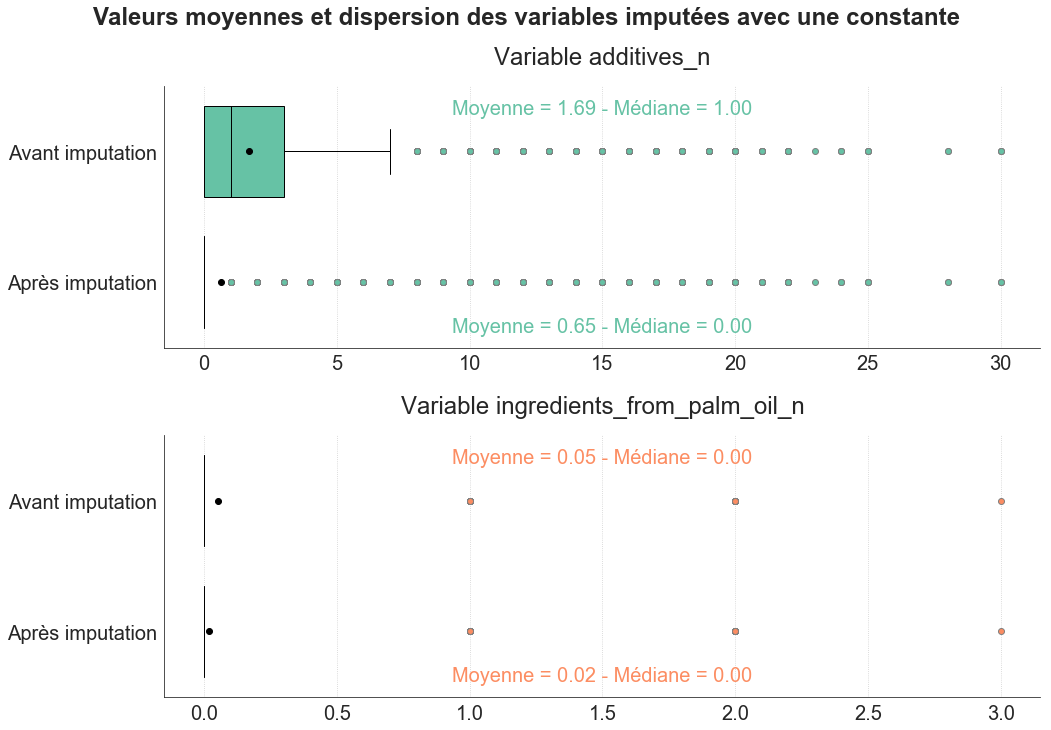

In [174]:
graph = sfg.MyGraph("Valeurs moyennes et dispersion des variables imputées avec une constante", 
                    nblin=len(col_imput_constante), nbcol=1, figsize=(15,10))
for i, col in enumerate(col_imput_constante):
    graph.add_boxplot([data[col], valeurs_avant_imput[i]], cat_labels=["Après imputation","Avant imputation"],
                      means=True, vertical=False, subtitle="Variable {}".format(col), multi_index=i+1)
for i, col in enumerate(col_imput_constante):
    x_mean = np.mean(graph.ax[i].get_xlim())
    graph.add_texts_boxplot(["Moyenne = {:.2f} - Médiane = {:.2f}".format(data[col].mean(), data[col].median()),
            "Moyenne = {:.2f} - Médiane = {:.2f}".format(np.mean(valeurs_avant_imput[i]), np.median(valeurs_avant_imput[i]))],
            x=[x_mean, x_mean], y=[0.66, 2.33], color=None, multi_index=i+1)
fig, ax = graph.fig, graph.ax
save_fig("117_boxplot_imputation_zero")
plt.show()

L'imputation par la constante 0 entraîne une baisse significative de la moyenne des 3 variables concernées.  
La médiane devient 0 pour les trois variables.

<a id='8_3'></a>

### 8.3. Vérification du nom des produits

Peut-on imputer les noms de produits manquants à partir de l'image des étiquettes ?

In [175]:
len(data[data.product_name.isna() & data.image_url.notna()])

942

In [176]:
len(data[data.product_name.isna() & data.image_url.notna()]) / len(data[data.product_name.isna()])

0.7251732101616628

<font color=red>Si l'on dispose des ressources de temps nécessaires, il est possible de compléter 942 valeurs manquantes de noms de produits à partir de l'image de l'étiquette, soit plus de 72% des valeurs manquantes de cette colonne.</font>

<a id='8_4'></a>

### 8.4. Imputation avec une valeur calculée : variables de mesures pour 100g

In [177]:
col_imput_calcul = ["proteins_100g", "fat_100g", "carbohydrates_100g", "salt_100g", "fiber_100g",
                    "saturated-fat_100g", "sugars_100g", "energy_100g"]

**Valeurs avant imputation**

In [178]:
valeurs_avant_imput = []
for col in col_imput_calcul:
    valeurs_avant_imput.append(list(data[col].dropna()))

#### 8.4.1. Première possibilité : imputation des valeurs manquantes avec la médiane

Je peux imputer les valeurs manquantes d'une variable avec la médiane de cette variable. Je préfère la médiane à la moyenne car elle est moins sensible aux outliers.

In [179]:
def imputation_median(df):
    col_imput_calcul = ["proteins_100g", "fat_100g", "carbohydrates_100g", "salt_100g", "fiber_100g",
                        "saturated-fat_100g", "sugars_100g", "energy_100g"]
    imputer_median = SimpleImputer(strategy='median')
    imputer_median.fit(df[col_imput_calcul])
    df.loc[:, col_imput_calcul] = imputer_median.transform(df[col_imput_calcul])
    return df, imputer_median.statistics_

In [180]:
verif_imputer_median, stats = imputation_median(data)
print(stats)

[6.00e+00 7.69e+00 1.40e+01 5.10e-01 1.60e+00 2.00e+00 3.60e+00 1.10e+03]


**Comparaison des distributions avant et après imputation**

In [181]:
txt_1, txt_2, x, y = [], [], [], []
for i, col in enumerate(col_imput_calcul[:-1]):
    txt_1.append("Moyenne = {:.2f}\nMédiane = {:.2f}".format(np.mean(valeurs_avant_imput[i]), np.median(valeurs_avant_imput[i])))
    txt_2.append("Moyenne = {:.2f}\nMédiane = {:.2f}".format(np.mean(verif_imputer_median[col]), np.median(verif_imputer_median[col])))
    y.append(i+1)
    if i % 2 == 0:
        x.append(115)
    elif i % 2 == 1:
        x.append(128)

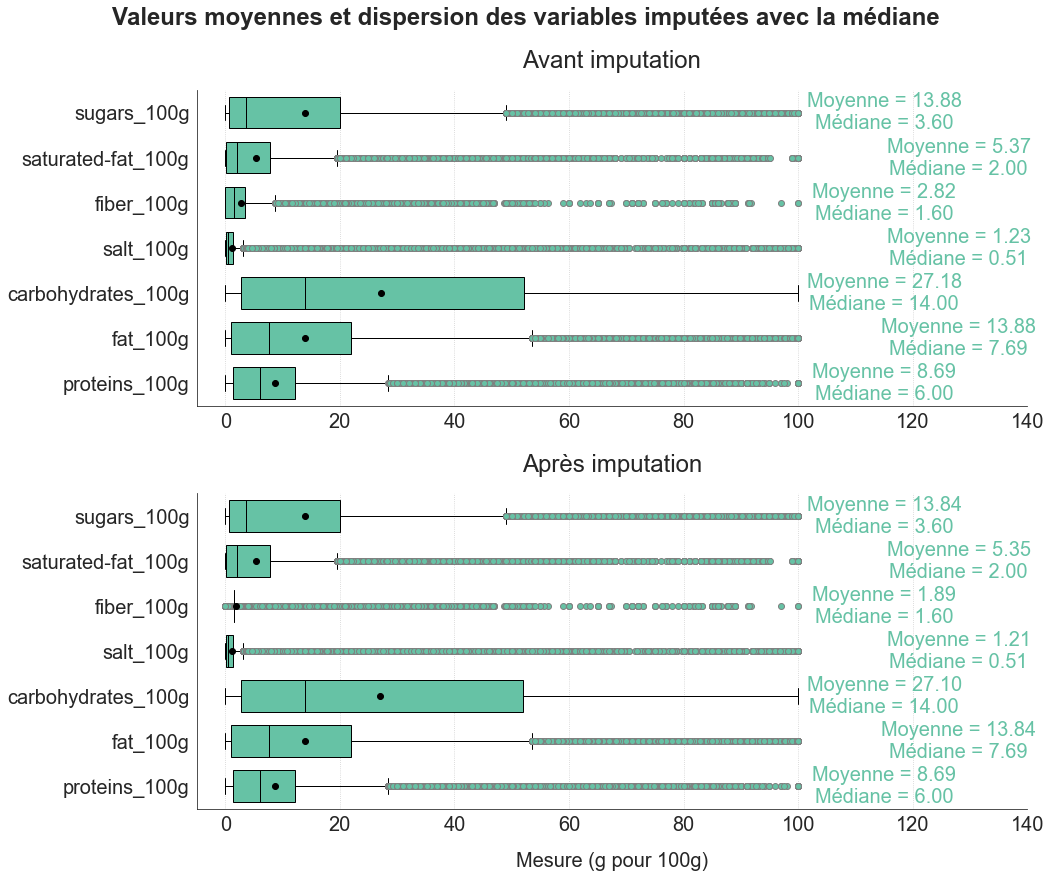

In [182]:
graph = sfg.MyGraph("Valeurs moyennes et dispersion des variables imputées avec la médiane", 
                    nblin=2, nbcol=1, figsize=(15,12))
graph.add_boxplot(valeurs_avant_imput[:-1], cat_labels=col_imput_calcul[:-1],
                      means=True, vertical=False, color_base_index=0, subtitle="Avant imputation", multi_index=1)
graph.add_boxplot(verif_imputer_median[col_imput_calcul[:-1]].values, cat_labels=col_imput_calcul[:-1],
                      means=True, vertical=False, color_base_index=0, subtitle="Après imputation", multi_index=2)
graph.set_axe_x(tick_max=140, multi_index=1)
graph.set_axe_x(label="Mesure (g pour 100g)", tick_max=140, multi_index=2)
graph.add_texts_boxplot(txt_1, x, y, multi_index=1)
graph.add_texts_boxplot(txt_2, x, y, multi_index=2)
fig, ax = graph.fig, graph.ax
save_fig("118_boxplot_imputation_mediane")
plt.show()

Comme nous imputons avec la médiane, la valeur des médianes ne change pas.  
La moyenne reste similaire pour chacune des variables.

#### 8.4.2. Deuxième possibilité : imputation des valeurs manquantes avec un kNN imputer

Je peux imputer les valeurs manquantes d'une variable grâce à un algorythme de kNN, qui calculera la valeur moyenne des k plus proches voisins. Cette estimation est plus précise que l'imputation par la moyenne ou la médiane.

In [183]:
def imputation_knn(df, n_neighbors=5):
    col_imput_calcul = ["proteins_100g", "fat_100g", "carbohydrates_100g", "salt_100g", "fiber_100g",
                        "saturated-fat_100g", "sugars_100g", "energy_100g"]
    imputer_knn = KNNImputer(n_neighbors=n_neighbors)
    imputer_knn.fit(df[col_imput_calcul])
    df.loc[:, col_imput_calcul] = imputer_knn.transform(df.loc[:, col_imput_calcul])
    return df

Je ne réalise la transformation que sur Google Collab car elle est très consommatrice en ressources.

In [184]:
n_neighbors = 5
if IN_COLAB:
    verif_imputer_knn = imputation_knn(data, n_neighbors)

**Comparaison des distributions avant et après imputation**

In [185]:
txt_1, txt_2, x, y = [], [], [], []
for i, col in enumerate(col_imput_calcul[:-1]):
    txt_1.append("Moyenne = {:.2f}\nMédiane = {:.2f}".format(np.mean(valeurs_avant_imput[i]), np.median(valeurs_avant_imput[i])))
    if IN_COLAB:
        txt_2.append("Moyenne = {:.2f}\nMédiane = {:.2f}".format(np.mean(verif_imputer_knn[col]), np.median(verif_imputer_knn[col])))
    y.append(i+1)
    if i % 2 == 0:
        x.append(115)
    elif i % 2 == 1:
        x.append(128)

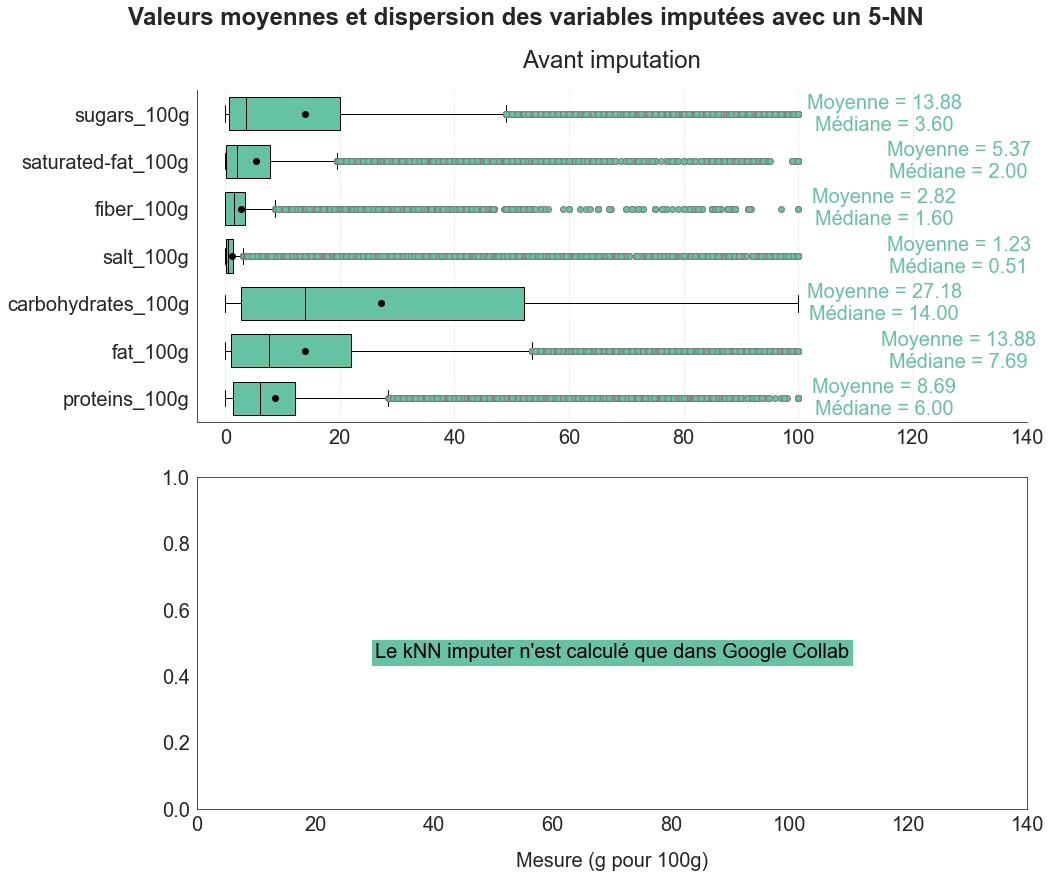

In [186]:
graph = sfg.MyGraph("Valeurs moyennes et dispersion des variables imputées avec un {}-NN".format(n_neighbors), 
                    nblin=2, nbcol=1, figsize=(15,12))
graph.add_boxplot(valeurs_avant_imput[:-1], cat_labels=col_imput_calcul[:-1],
                      means=True, vertical=False, color_base_index=0, subtitle="Avant imputation", multi_index=1)
if IN_COLAB:
    graph.add_boxplot(verif_imputer_knn[col_imput_calcul[:-1]].values, cat_labels=col_imput_calcul[:-1],
                      means=True, vertical=False, color_base_index=0, subtitle="Après imputation", multi_index=2)
else:
    graph.add_text(70, 0.5, "Le kNN imputer n'est calculé que dans Google Collab", multi_index=2)
graph.set_axe_x(tick_max=140, multi_index=1)
graph.set_axe_x(label="Mesure (g pour 100g)", tick_max=140, multi_index=2)
graph.add_texts_boxplot(txt_1, x, y, multi_index=1)
graph.add_texts_boxplot(txt_2, x, y, multi_index=2)
fig, ax = graph.fig, graph.ax
save_fig("119_boxplot_imputation_5nn")
plt.show()

Les moyennes sont moins impactées en utilisant une imputation par kNN, par rapport à une imputation avec la médiane.  
Les médianes sont identiques, excepté pour le sel qui est la variable avec le plus de valeurs manquantes.

In [187]:
if IN_COLAB:
    title = "Variable 'energy_100g' - Imputation par la médiane et par un {}-NN".format(n_neighbors)
    check_values = [valeurs_avant_imput[-1], verif_imputer_median[col_imput_calcul[-1]].values, \
                   verif_imputer_knn[col_imput_calcul[-1]].values]
    cat_labels=["Avant imputation","Après imputation par la médiane","Après imputation par un 5-NN"]
    txt, x, y = [], [], []
    for i in range(3):
        txt.append("Moyenne = {:.2f}\nMédiane = {:.2f}".format(np.mean(check_values[i]), np.median(check_values[i])))
        y.append(i+0.66)
        x.append(2500)
else:
    title = "Variable 'energy_100g' - Imputation par la médiane"
    check_values = [valeurs_avant_imput[-1], verif_imputer_median[col_imput_calcul[-1]].values]
    cat_labels=["Avant imputation","Après imputation par la médiane"]
    txt, x, y = [], [], []
    for i in range(2):
        txt.append("Moyenne = {:.2f}\nMédiane = {:.2f}".format(np.mean(check_values[i]), np.median(check_values[i])))
        y.append(i+0.75)
        x.append(2500)

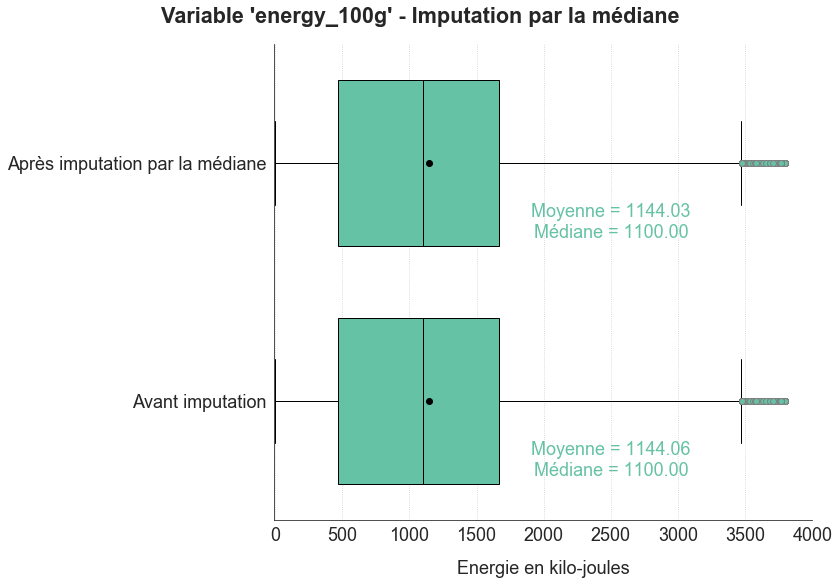

In [188]:
graph = sfg.MyGraph(title)
graph.add_boxplot(check_values, cat_labels=cat_labels, means=True, vertical=False)
graph.add_texts_boxplot(txt, x, y)
graph.set_axe_x(label="Energie en kilo-joules", tick_min=-10, tick_max=4000)
fig, ax = graph.fig, graph.ax
save_fig("120_boxplot_imputation_energy")
plt.show()

#### 8.4.3. Sauvegarde de l'imputation retenue

<font color=red>Si je bénéficie de suffisamment de capacités de calcul, j'opte pour le kNN imputer. Sinon, j'impute par la médiane.</font>

In [189]:
if IN_COLAB:
    data = verif_imputer_knn.copy()
else:
    data = verif_imputer_median.copy()

<a id='8_5'></a>

### 8.5. Vérification du respect des contraintes numériques après l'imputation

Je dois vérifier que les variables respectent les contraintes numériques après l'imputation :
- les valeurs nutritionnelles et de comptage doivent être positives : comme j'impute à partir de valeurs toutes positives, cette vérification n'est pas nécessaire ;
- les valeurs nutritionnelles (excepté l'énergie) ne doivent pas excéder 100g : comme j'impute à partir de valeurs nutritionnelles toutes inférieures à 100g, cette vérification n'est pas nécessaire ;
- l'énergie doit être inférieure ou égale à 3800 kJ : comme j'impute à partir de valeurs énergétiques toutes inférieures ou égales à 3800 kJ, cette vérification n'est pas nécessaire ;
- saturated-fat_100g ne doit pas excéder fat_100g : si c'est le cas, je ne sais pas si c'est dû à l'imputation de saturated-fat_100g ou de fat_100g. Je supprime les lignes concernées par cette mauvaise imputation ;
- sugars_100g ne doit pas excéder carbohydrates_100g : si c'est le cas, je ne sais pas si c'est dû à l'imputation de sugars_100g ou de carbohydrates_100g. Je supprime les lignes concernées par cette mauvaise imputation ;
- la somme des macro-nutriments ne doit pas excéder 100g : si c'est le cas, je ne sais pas quelle imputation est à l'origine de cet excès. Je supprime les lignes concernées.

In [190]:
data = correct_saturated_fat(data)
data = correct_sugars(data)
data = correct_sum_over100g(data)

<a id='8_6'></a>

### 8.6. Nettoyages supplémentaires déduits de l'analyse des données

Lors de mon analyse des données, d'autres nettoyages sont apparus nécessaires. Je les rajoute ici.

#### 8.6.1. Recalcul de la variable energy_100g

**Erreur détectée**

L'analyse bi-variée des variables energy_100g et fat_100g laisse apparaître des valeurs aberrantes.

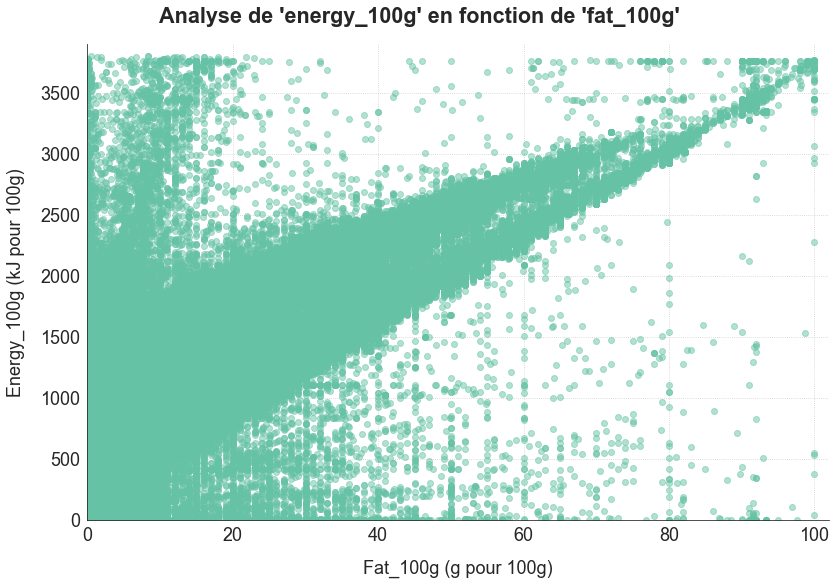

In [191]:
graph = sfg.MyGraph("Analyse de 'energy_100g' en fonction de 'fat_100g'")
graph.add_plot(data.fat_100g, data.energy_100g, marker='o', linestyle='', alpha=0.5, with_grid='both', grid_style=':')
graph.set_axe_x(label="Fat_100g (g pour 100g)", tick_min=0, tick_max=102)
graph.set_axe_y(label="Energy_100g (kJ pour 100g)", tick_min=0, tick_max=3900)
fig, ax  = graph.fig, graph.ax
save_fig("121_detection_erreur_energy")
plt.show()

Lorsque la quantité de graisse pour 100g est élevée, nous devrions avoir une valeur énergétique élevée, car un gramme de graisse apporte 38 kJ d'énergie.  
A l'inverse, avec peu de graisse dans le produit, la quantité énergétique ne peut pas dépasser les 2000 kJ car les autres catégories nutritionnelles apportent au plus 17 kJ par gramme.  
Le graphique montre qu'un grand nombre de valeurs énergétiques sont fausses.

**Calcul de la valeur énergétique théorique**

Je décide de recalculer la valeur énergétique théorique, en fonction des informations nutritionnelles sur les graisses, les protéines, les glucides et les fibres, qui sont les quatre contributeurs de l'apport énergétique d'un aliment.

Pour rappel :
- un gramme de fibre fournit 8 kJ (ou 1,9 kcal) ;
- un gramme de glucide ou de protéine fournit 17 kJ (ou 4 kcal) ;
- un gramme de lipide fournit 38 kJ (ou 9 kcal) ;

In [192]:
energy_calculated = 38 * data.fat_100g + 17 * (data.carbohydrates_100g + data.proteins_100g) + 8 * data.fiber_100g

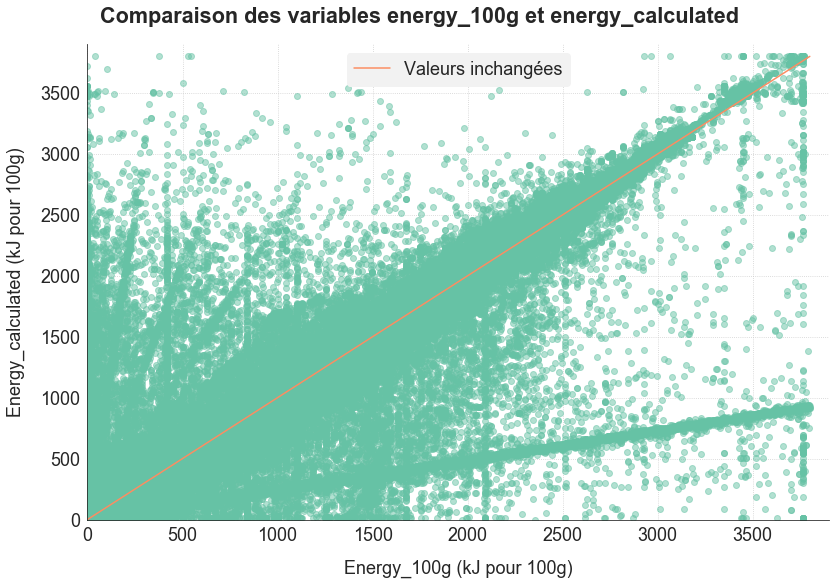

In [193]:
graph = sfg.MyGraph("Comparaison des variables energy_100g et energy_calculated")
graph.add_plot(data.energy_100g, energy_calculated, label="", marker='o', linestyle='', alpha=0.5, with_grid='both', grid_style=':')
graph.add_plot([0,3800], [0,3800], label="Valeurs inchangées", legend=True)
graph.set_axe_x(label="Energy_100g (kJ pour 100g)", tick_min=0, tick_max=3900)
graph.set_axe_y(label="Energy_calculated (kJ pour 100g)", tick_min=0, tick_max=3900)
fig, ax  = graph.fig, graph.ax
save_fig("122_comparaison_energy")
plt.show()

De nombreuses valeurs de 'energy_100g' s'éloignent fortement de leur valeur théorique 'energy_calculated', dans le deux sens : sous-estimation et sur-estimation.  
<font color=red>Je remplace toutes les valeurs de 'energy_100g' par la valeur théorique calculée.</font>

**Correction des données**

In [194]:
def calcul_theorical_energy(df):
    df["energy_100g"] = 38 * df.fat_100g + 17 * (df.carbohydrates_100g + df.proteins_100g) + 8 * df.fiber_100g
    return df

In [195]:
data = calcul_theorical_energy(data)

#### 8.6.2. Erreurs dans le rapport entre le score et la catégorie nutriscore

**Observation de l'erreur**

In [196]:
valeurs = []
cat_labels = np.sort(data[data.nutriscore_grade.notna()].nutriscore_grade.unique())
for g in cat_labels:
    valeurs.append(data[data.nutriscore_grade==g].nutriscore_score)

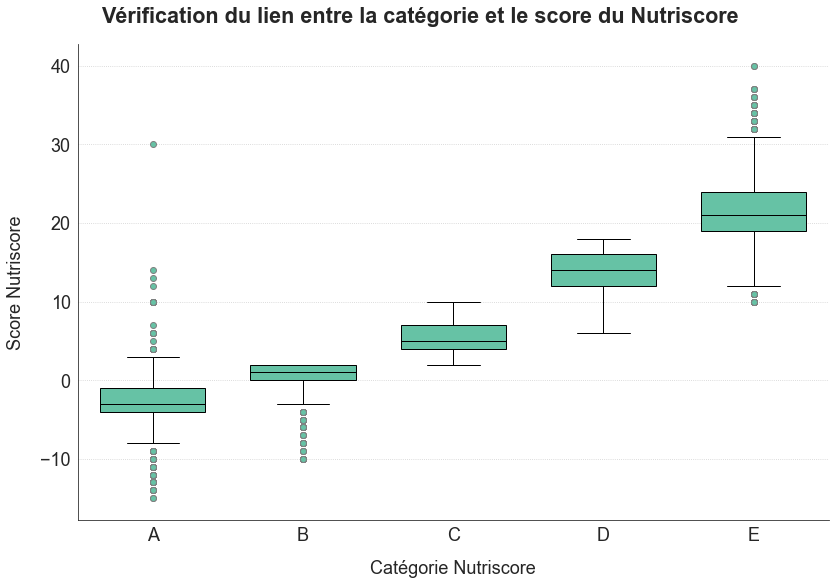

In [197]:
graph = sfg.MyGraph(title="Vérification du lien entre la catégorie et le score du Nutriscore")
graph.add_boxplot(valeurs, cat_labels=np.char.upper(cat_labels.astype(np.unicode_)))
graph.set_axe_x(label="Catégorie Nutriscore")
graph.set_axe_y(label="Score Nutriscore")
fig, ax = graph.fig, graph.ax
save_fig("123_verif_nutriscore_score_grade")
plt.show()

Nous avons des chevauchements, qui s'expliquent par des classements différents pour les aliments solides et les boissons.

Aliments solides | Boissons | Catégorie
--- | --- | ---
-15 à -1 | Eaux | A
0 à 2 | -15 à 1 | B
3 à 10 | 2 à 5 | C
11 à 18 | 6 à 9 | D
19 à 40 | 10 à 40 | E

A part les valeurs supérieures à 0 pour la catégorie A (les eaux minérales obtiennent un score de 0 et sont classées en catégorie A), la distribution des nutriscores en fonction des catégories correspond au tableau théorique.  
<font color=red>Je supprime les lignes où le nutriscore_grade vaut A et le nutriscore_score est strictement supérieur à 0.</font>

**Correction de l'erreur**

In [198]:
print("Il y a {} enregistrements dont le score et la catégorie de nutriscore ne sont pas cohérents".\
      format(len(data[((data.nutriscore_grade=='a') | (data.nutriscore_grade=='A')) & (data.nutriscore_score > 0)])))

Il y a 92 enregistrements dont le score et la catégorie de nutriscore ne sont pas cohérents


In [199]:
def correct_nutriscore_nutrigrade(df):
    index_to_drop = list(df[((df.nutriscore_grade=='a') | (df.nutriscore_grade=='A')) & (df.nutriscore_score > 0)].index)
    if index_to_drop:
        df.drop(index_to_drop, inplace=True)
    return df

In [200]:
data = correct_nutriscore_nutrigrade(data)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 518892 entries, 0000000000017 to 99999995
Data columns (total 15 columns):
product_name                   517634 non-null object
image_url                      469086 non-null object
proteins_100g                  518892 non-null float64
fat_100g                       518892 non-null float64
carbohydrates_100g             518892 non-null float64
salt_100g                      518892 non-null float64
fiber_100g                     518892 non-null float64
saturated-fat_100g             518892 non-null float64
sugars_100g                    518892 non-null float64
energy_100g                    518892 non-null float64
nutriscore_score               223109 non-null float64
nutriscore_grade               223109 non-null object
ingredients_from_palm_oil_n    518892 non-null float64
additives_n                    518892 non-null float64
is_bio                         518892 non-null bool
dtypes: bool(1), float64(11), object(3)
memory usage: 59.9+ M

---
<a id='9_0'></a>

## <font color=blue>9. Sauvegarde des données nettoyées</font>

In [201]:
if IN_COLAB:
    save_name = PATH_DRIVE + "/" + "openfoodfacts_clean_knn.csv"
else:
    save_name = "openfoodfacts_clean_median.csv"
data.to_csv(save_name)